## Capstone Project
Supervisor: Ram \
Data Scientists: Anthony & Keiji

## Problem Statement:

* Machine \
The company wants to be aware of the top 10 causes of downtime and its occurrence frequency/patterns so as to plan ahead before the downtime occurs.


* Man \
With efforts to recognize employees' performance, the company wants to reward the best technician/repairs each year but do not know how to measure/judge their performance as they are considered a more technical role.

Additionally, in order to reduce the overall downtime, the company wants to set a target Repair Hours for the technician/repairer but do not have the data to do so and therefore unable to increase the Overall Equipment Efficiency (OEE). 


## Project Design:
* Using EDA to find out the: \
Top 10 reasons for chemical line downtime over the past 6 years
Occurrence frequency of each of the top 10 downtime reasons


* Using machine learning to find out: \
Predict the repair hours of each of the downtime reasons in future

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split , GridSearchCV , RandomizedSearchCV
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Load dataset
data = pd.read_excel("IL DES Line 4 Breakdown Data.xlsx")
pd.set_option('display.max_columns', None)
data.head()

,ID.No,MC.No,Area,MC.Name,Report Date & Time,Problem Description,M/C Status When Attend,M/C Status During Repair,M/C Status After Attend,No of people attend,Action Taken,Actual Repair Start Time(Attend Date),Troubleshoot Complete Time,Actual Repair Complete Time(Complete Date),Fab/Spare parts sourcing Time(mins),Breakdown Repair Category,KIV Reason,Parts Required,Qty Required,Wait AM/PM,Attend Wait time (mins),Troubleshoot Hours (mins),Rectify Hours (mins),Repair Hours (mins),Remarks,Repairer 1,Repairer 2,User_Feedback,Feedback_By,Feedback_Entry_Time
0,216422,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-02-20 03:55:15,few rollers with loose 'o' ring causing pnl ov...,SWA,SDR,OK,1.0,replace some worn out oring @ develoving roller,2014-02-20 04:00:00,2014-02-20 04:35:00,2014-02-20 04:35:00,0.0,MWT,Not Applicable,NaN,0.0,PM,5.0,35.0,0.0,35.0,NaN,JERSON CASTRO (MN),NaN,NaN,NaN,NaN
1,216864,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-02-26 16:53:06,dev system level sensor data jammed...chemical...,SWA,SDR,OK,1.0,clean sensor and reset system.,2014-02-26 17:00:00,2014-02-26 17:50:00,2014-02-26 17:50:00,0.0,EBD,Not Applicable,NaN,0.0,AM,7.0,50.0,0.0,50.0,NaN,LI YONGXIN (MN),NaN,NaN,NaN,NaN
2,219122,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-03-31 05:12:26,filter pipe leaking,NP,NP,OK,1.0,replace the pvc filter connector.,2014-03-31 05:30:00,2014-03-31 06:00:00,2014-03-31 06:00:00,0.0,PVC,Not Applicable,NaN,0.0,PM,18.0,30.0,0.0,30.0,NaN,JERSON CASTRO (MN),NaN,NaN,NaN,NaN
3,220959,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-04-28 20:47:53,air hose leaking,RWA,RDR,OK,1.0,-trim and re-connect broken airhose.,2014-04-28 21:00:00,2014-04-28 21:15:00,2014-04-28 21:15:00,0.0,PWT,Not Applicable,NaN,0.0,PM,13.0,15.0,0.0,15.0,NaN,DENNIS DAUZ (MN),NaN,NaN,NaN,NaN
4,222147,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-05-19 14:04:31,air leakage,RWA,RDR,OK,1.0,replace air connector.,2014-05-19 14:40:00,2014-05-19 15:00:00,2014-05-19 15:00:00,0.0,PWT,Not Applicable,NaN,0.0,AM,36.0,20.0,0.0,20.0,NaN,LI YONGXIN (MN),NaN,NaN,NaN,NaN


## Dataset definition:
1. ID. No - serial no of trouble logging for entire company
2. MC. No - Designated name/number for each module of the chemical line
3. Area - Designated name/number of production area
4. MC. Name - Name input by maintenance when machine/line first installed
5. Report Date & Time: Entry input date (MM/DD/YYYY) and time (HH:MM)
6. Problem Description - Description manually input by operators
7. M/C Status When Attend - Manual input by maintenance engineer, either 'RWA', 'SWA', 'NP' (Definition tbc)
8. M/C Status During Repair - Manual input by maintenance engineer, either 'RDR', 'SDR', 'NP', 'SRP' (Definition tbc) 
9. M/C Status After Attend - Manual input by maintenance engineer, either 'OK', 'nil', 'KIVR' (KIV Repair)
10. No of People Attend - Manual input of No of technician assisted by maintenance engineer,
11. Actions Taken: Manual input of work done by maintenance engineer 
12. Actual Repair Start Time(Attend Date) - Entry input date (YYYY-MM-DD) and time (HH:MM:SS)
13. Troubleshoot Complete Time - Entry input date (YYYY-MM-DD) and time (HH:MM:SS)
14. Actual Repair Complete Time(Complete Date) - Entry input date (YYYY-MM-DD) and time (HH:MM:SS)
15. Fab/Spare parts sourcing Time(mins) - Entry input time of spare parts sourcing (in minutes)
16. Breakdown Repair Category - Manual input by maintenance engineer,  either EBD, PMP, MWT, EWT, PVC, EAL, MAL, OTH, PWT, FAC, MTR, PAL, MSO (Definition tbc)
17. KIV Reason - Whether repair is on hold, either 'Not Applicable' or 'No Spare Part'
18. Parts Required - Parts required for the repair job
19. Qty Required - Quantity required for the parts required
20. Wait AM/PM - Waiting time is it morning or night shift, auto input based on raised entry of maintenance ticket            
21. Attend Wait Time (Mins) - Waiting time before maintenance engineer attend to machine
22. Troubleshooting Hours (Mins) - Troubleshooting time input by maintenance engineer
23. Rectify Hours (Mins) - Rectify time input by maintenance engineer
24. Repair Hours (Mins) - Actual repair time input by maintenance engineer
25. Remarks - Manual input by maintenance engineer
26. Repairer 1 - Name of first maintenance engineer
27. Repairer 2 - Name of second maintenance engineer
28. User_Feedback - Feedback by Operator if any 
29. Feedback_By - Operator whom do the feedback 
30. Feedback_Entry_Time - Feedback submission date (MM/DD/YYYY) and time (HH:MM)


# 1. Pre-Processing of Dataset

In [3]:
# Check total rows and columns of the dataset
data.shape

(700, 30)

In [4]:
# Check for any null values in the dataset
data.isnull().values.any()

True

In [5]:
# Find out the breakdown of null values in different columns
data.isna().sum()

ID.No                                           0
MC.No                                           0
Area                                            0
MC.Name                                         0
Report Date & Time                              0
Problem Description                             0
M/C Status When Attend                          3
M/C Status During Repair                        3
M/C Status After Attend                         0
No of people attend                             3
Action Taken                                    3
Actual Repair Start Time(Attend Date)           6
Troubleshoot Complete Time                      6
Actual Repair Complete Time(Complete Date)      6
Fab/Spare parts sourcing Time(mins)             6
Breakdown Repair Category                       6
KIV Reason                                      6
Parts Required                                700
Qty Required                                    6
Wait AM/PM                                      3


In [6]:
# Find out if there's any duplicated entries
data.duplicated().sum()

0

## Approach 1
Since there are 5 columns that have null values for all 700 columns, therefore we will drop the columns:
- Parts Required
- Remarks
- User_Feedback
- Feedback_By
- Feedback_Entry_Time

In [7]:
# Check dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   ID.No                                       700 non-null    int64         
 1   MC.No                                       700 non-null    object        
 2   Area                                        700 non-null    object        
 3   MC.Name                                     700 non-null    object        
 4   Report Date & Time                          700 non-null    datetime64[ns]
 5   Problem Description                         700 non-null    object        
 6   M/C Status When Attend                      697 non-null    object        
 7   M/C Status During Repair                    697 non-null    object        
 8   M/C Status After Attend                     700 non-null    object        
 9   No of peop

In [8]:
# Get column names
data.columns

Index(['ID.No ', 'MC.No ', 'Area ', 'MC.Name ', 'Report Date & Time',
       'Problem Description', 'M/C Status When Attend ',
       'M/C Status During Repair', 'M/C Status After Attend',
       'No of people attend', 'Action Taken',
       'Actual Repair Start Time(Attend Date) ', 'Troubleshoot Complete Time',
       'Actual Repair Complete Time(Complete Date)',
       'Fab/Spare parts sourcing Time(mins)', 'Breakdown Repair Category ',
       'KIV Reason ', 'Parts Required ', 'Qty Required ', 'Wait AM/PM ',
       'Attend Wait time (mins) ', 'Troubleshoot Hours (mins) ',
       'Rectify Hours (mins) ', 'Repair Hours (mins) ', 'Remarks ',
       'Repairer 1', 'Repairer 2', 'User_Feedback ', 'Feedback_By ',
       'Feedback_Entry_Time '],
      dtype='object')

In [9]:
# Copy original dataset to retain integrity
data1 = data.copy()

# Drop 5 Colmuns with all null values: Parts Required, Remarks, User_Feedback, Feedback_By, Feedback_Entry_Time
data1 = data1.drop(data1.columns[[17, 24, 27, 28, 29]], axis=1)
data1.head()

,ID.No,MC.No,Area,MC.Name,Report Date & Time,Problem Description,M/C Status When Attend,M/C Status During Repair,M/C Status After Attend,No of people attend,Action Taken,Actual Repair Start Time(Attend Date),Troubleshoot Complete Time,Actual Repair Complete Time(Complete Date),Fab/Spare parts sourcing Time(mins),Breakdown Repair Category,KIV Reason,Qty Required,Wait AM/PM,Attend Wait time (mins),Troubleshoot Hours (mins),Rectify Hours (mins),Repair Hours (mins),Repairer 1,Repairer 2
0,216422,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-02-20 03:55:15,few rollers with loose 'o' ring causing pnl ov...,SWA,SDR,OK,1.0,replace some worn out oring @ develoving roller,2014-02-20 04:00:00,2014-02-20 04:35:00,2014-02-20 04:35:00,0.0,MWT,Not Applicable,0.0,PM,5.0,35.0,0.0,35.0,JERSON CASTRO (MN),NaN
1,216864,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-02-26 16:53:06,dev system level sensor data jammed...chemical...,SWA,SDR,OK,1.0,clean sensor and reset system.,2014-02-26 17:00:00,2014-02-26 17:50:00,2014-02-26 17:50:00,0.0,EBD,Not Applicable,0.0,AM,7.0,50.0,0.0,50.0,LI YONGXIN (MN),NaN
2,219122,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-03-31 05:12:26,filter pipe leaking,NP,NP,OK,1.0,replace the pvc filter connector.,2014-03-31 05:30:00,2014-03-31 06:00:00,2014-03-31 06:00:00,0.0,PVC,Not Applicable,0.0,PM,18.0,30.0,0.0,30.0,JERSON CASTRO (MN),NaN
3,220959,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-04-28 20:47:53,air hose leaking,RWA,RDR,OK,1.0,-trim and re-connect broken airhose.,2014-04-28 21:00:00,2014-04-28 21:15:00,2014-04-28 21:15:00,0.0,PWT,Not Applicable,0.0,PM,13.0,15.0,0.0,15.0,DENNIS DAUZ (MN),NaN
4,222147,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-05-19 14:04:31,air leakage,RWA,RDR,OK,1.0,replace air connector.,2014-05-19 14:40:00,2014-05-19 15:00:00,2014-05-19 15:00:00,0.0,PWT,Not Applicable,0.0,AM,36.0,20.0,0.0,20.0,LI YONGXIN (MN),NaN


In [10]:
# Check again for null values after dropping the 5 columns
data1.isna().sum()

ID.No                                           0
MC.No                                           0
Area                                            0
MC.Name                                         0
Report Date & Time                              0
Problem Description                             0
M/C Status When Attend                          3
M/C Status During Repair                        3
M/C Status After Attend                         0
No of people attend                             3
Action Taken                                    3
Actual Repair Start Time(Attend Date)           6
Troubleshoot Complete Time                      6
Actual Repair Complete Time(Complete Date)      6
Fab/Spare parts sourcing Time(mins)             6
Breakdown Repair Category                       6
KIV Reason                                      6
Qty Required                                    6
Wait AM/PM                                      3
Attend Wait time (mins)                         6


## Approach 2
We assume that those with null values in 'Repairer 2' Column is because there's only 1 repairer
* Replace the Null Values in 'Repairer 2' Column with "No Repairer 2" (String)

In [11]:
# Replace 'Repairer 2' Column null cells with "No Repairer 2"

data1['Repairer 2'] = data1['Repairer 2'].fillna("No Repairer 2")

In [12]:
# Display only thos rows with null values
data1[data1.isna().any(axis=1)]

,ID.No,MC.No,Area,MC.Name,Report Date & Time,Problem Description,M/C Status When Attend,M/C Status During Repair,M/C Status After Attend,No of people attend,Action Taken,Actual Repair Start Time(Attend Date),Troubleshoot Complete Time,Actual Repair Complete Time(Complete Date),Fab/Spare parts sourcing Time(mins),Breakdown Repair Category,KIV Reason,Qty Required,Wait AM/PM,Attend Wait time (mins),Troubleshoot Hours (mins),Rectify Hours (mins),Repair Hours (mins),Repairer 1,Repairer 2
448,294973,L110DV,NC-B314,DES 4-Chemical Developing 3,2017-10-13 02:21:34,developing make-up tank sensor level not working,NaN,NaN,nil,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,PM,NaN,NaN,NaN,NaN,NaN,No Repairer 2
494,297310,L118ET,NC-B314,DES 4-Etching Chamber 5,2017-11-27 07:32:57,etching m15 sensor problem,NaN,NaN,nil,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,PM,NaN,NaN,NaN,NaN,NaN,No Repairer 2
578,306056,L119ET,NC-B314,IL DES 4-Etching Chamber 6,2018-05-25 08:56:17,hci dosing pump haing problem ..hcl keep dosin...,RWA,RDR,OK,1.0,"check AQUA controller and sensor ok, check the...",NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Repairer 2
579,306476,L119ET,NC-B314,IL DES 4-Etching Chamber 6,2018-06-04 05:51:54,etching door sensor problem cot not start mc,SWA,SDR,OK,1.0,change safety door s/w On module 13,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Repairer 2
580,307416,L119ET,NC-B314,IL DES 4-Etching Chamber 6,2018-06-22 11:44:17,re-cycle fecl meter c no data display...,RWA,RDR,OK,1.0,replace the battery on 25/06,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Repairer 2
626,302311,L127WA,NC-B314,DES 4-Water Rinse,2018-03-04 01:09:02,water pipe leaking,NaN,NaN,nil,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,PM,NaN,NaN,NaN,NaN,NaN,No Repairer 2


## Approach 3
With 6 rows of the data have multiple null values
* Drop All the 6 Rows with the Null Values


In [13]:
# Drop all rows with the null values in dataset
Final_data = data1.dropna()
Final_data.head()

,ID.No,MC.No,Area,MC.Name,Report Date & Time,Problem Description,M/C Status When Attend,M/C Status During Repair,M/C Status After Attend,No of people attend,Action Taken,Actual Repair Start Time(Attend Date),Troubleshoot Complete Time,Actual Repair Complete Time(Complete Date),Fab/Spare parts sourcing Time(mins),Breakdown Repair Category,KIV Reason,Qty Required,Wait AM/PM,Attend Wait time (mins),Troubleshoot Hours (mins),Rectify Hours (mins),Repair Hours (mins),Repairer 1,Repairer 2
0,216422,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-02-20 03:55:15,few rollers with loose 'o' ring causing pnl ov...,SWA,SDR,OK,1.0,replace some worn out oring @ develoving roller,2014-02-20 04:00:00,2014-02-20 04:35:00,2014-02-20 04:35:00,0.0,MWT,Not Applicable,0.0,PM,5.0,35.0,0.0,35.0,JERSON CASTRO (MN),No Repairer 2
1,216864,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-02-26 16:53:06,dev system level sensor data jammed...chemical...,SWA,SDR,OK,1.0,clean sensor and reset system.,2014-02-26 17:00:00,2014-02-26 17:50:00,2014-02-26 17:50:00,0.0,EBD,Not Applicable,0.0,AM,7.0,50.0,0.0,50.0,LI YONGXIN (MN),No Repairer 2
2,219122,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-03-31 05:12:26,filter pipe leaking,NP,NP,OK,1.0,replace the pvc filter connector.,2014-03-31 05:30:00,2014-03-31 06:00:00,2014-03-31 06:00:00,0.0,PVC,Not Applicable,0.0,PM,18.0,30.0,0.0,30.0,JERSON CASTRO (MN),No Repairer 2
3,220959,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-04-28 20:47:53,air hose leaking,RWA,RDR,OK,1.0,-trim and re-connect broken airhose.,2014-04-28 21:00:00,2014-04-28 21:15:00,2014-04-28 21:15:00,0.0,PWT,Not Applicable,0.0,PM,13.0,15.0,0.0,15.0,DENNIS DAUZ (MN),No Repairer 2
4,222147,L108DV,NC-B314,DES 4-Chemical Developing 1,2014-05-19 14:04:31,air leakage,RWA,RDR,OK,1.0,replace air connector.,2014-05-19 14:40:00,2014-05-19 15:00:00,2014-05-19 15:00:00,0.0,PWT,Not Applicable,0.0,AM,36.0,20.0,0.0,20.0,LI YONGXIN (MN),No Repairer 2


In [14]:
# Check again for any null values in dataset
Final_data.isna().sum()

ID.No                                         0
MC.No                                         0
Area                                          0
MC.Name                                       0
Report Date & Time                            0
Problem Description                           0
M/C Status When Attend                        0
M/C Status During Repair                      0
M/C Status After Attend                       0
No of people attend                           0
Action Taken                                  0
Actual Repair Start Time(Attend Date)         0
Troubleshoot Complete Time                    0
Actual Repair Complete Time(Complete Date)    0
Fab/Spare parts sourcing Time(mins)           0
Breakdown Repair Category                     0
KIV Reason                                    0
Qty Required                                  0
Wait AM/PM                                    0
Attend Wait time (mins)                       0
Troubleshoot Hours (mins)               

In [15]:
# Check processed dataset's total number of rows and columns
Final_data.shape

(694, 25)

In [16]:
# Info of Final Data
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694 entries, 0 to 699
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   ID.No                                       694 non-null    int64         
 1   MC.No                                       694 non-null    object        
 2   Area                                        694 non-null    object        
 3   MC.Name                                     694 non-null    object        
 4   Report Date & Time                          694 non-null    datetime64[ns]
 5   Problem Description                         694 non-null    object        
 6   M/C Status When Attend                      694 non-null    object        
 7   M/C Status During Repair                    694 non-null    object        
 8   M/C Status After Attend                     694 non-null    object        
 9   No of peop

## Processed Data: Final_data
* No Null Values in the data
* Total number of rows: 694
* Total number of columns: 25

We will further drop columns which are not useful for EDA or have any correlation in the Final_data


Columns to Drop:
* ID.No
* Area

In [17]:
# Further dropping of non-useful columns
Final_data = Final_data.drop(data1.columns[[0, 2]], axis=1)
Final_data.head()

,MC.No,MC.Name,Report Date & Time,Problem Description,M/C Status When Attend,M/C Status During Repair,M/C Status After Attend,No of people attend,Action Taken,Actual Repair Start Time(Attend Date),Troubleshoot Complete Time,Actual Repair Complete Time(Complete Date),Fab/Spare parts sourcing Time(mins),Breakdown Repair Category,KIV Reason,Qty Required,Wait AM/PM,Attend Wait time (mins),Troubleshoot Hours (mins),Rectify Hours (mins),Repair Hours (mins),Repairer 1,Repairer 2
0,L108DV,DES 4-Chemical Developing 1,2014-02-20 03:55:15,few rollers with loose 'o' ring causing pnl ov...,SWA,SDR,OK,1.0,replace some worn out oring @ develoving roller,2014-02-20 04:00:00,2014-02-20 04:35:00,2014-02-20 04:35:00,0.0,MWT,Not Applicable,0.0,PM,5.0,35.0,0.0,35.0,JERSON CASTRO (MN),No Repairer 2
1,L108DV,DES 4-Chemical Developing 1,2014-02-26 16:53:06,dev system level sensor data jammed...chemical...,SWA,SDR,OK,1.0,clean sensor and reset system.,2014-02-26 17:00:00,2014-02-26 17:50:00,2014-02-26 17:50:00,0.0,EBD,Not Applicable,0.0,AM,7.0,50.0,0.0,50.0,LI YONGXIN (MN),No Repairer 2
2,L108DV,DES 4-Chemical Developing 1,2014-03-31 05:12:26,filter pipe leaking,NP,NP,OK,1.0,replace the pvc filter connector.,2014-03-31 05:30:00,2014-03-31 06:00:00,2014-03-31 06:00:00,0.0,PVC,Not Applicable,0.0,PM,18.0,30.0,0.0,30.0,JERSON CASTRO (MN),No Repairer 2
3,L108DV,DES 4-Chemical Developing 1,2014-04-28 20:47:53,air hose leaking,RWA,RDR,OK,1.0,-trim and re-connect broken airhose.,2014-04-28 21:00:00,2014-04-28 21:15:00,2014-04-28 21:15:00,0.0,PWT,Not Applicable,0.0,PM,13.0,15.0,0.0,15.0,DENNIS DAUZ (MN),No Repairer 2
4,L108DV,DES 4-Chemical Developing 1,2014-05-19 14:04:31,air leakage,RWA,RDR,OK,1.0,replace air connector.,2014-05-19 14:40:00,2014-05-19 15:00:00,2014-05-19 15:00:00,0.0,PWT,Not Applicable,0.0,AM,36.0,20.0,0.0,20.0,LI YONGXIN (MN),No Repairer 2


## 2. Studying of Data in Dataset

* To examine the datasets

Text(0, 0.5, 'MC.No')

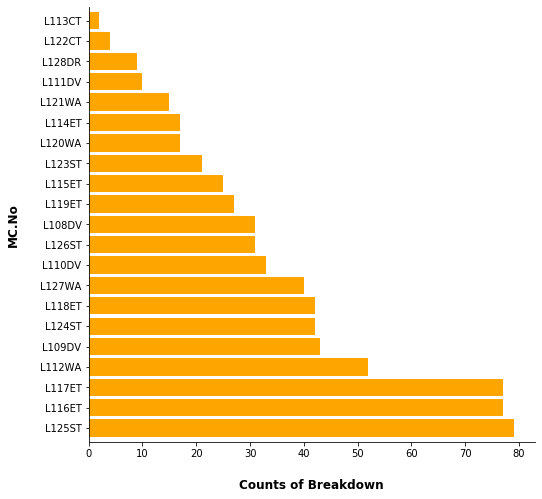

In [18]:
# Check of unique entries of machine number
ax = Final_data['MC.No '].value_counts().plot(kind='barh', figsize=(8, 8), color='orange', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set x-axis label
ax.set_xlabel("Counts of Breakdown", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("MC.No", labelpad=20, weight='bold', size=12)

* Total of 21 unqiue machine numbers (21 modules out of 23 modules) are in the dataset

Text(0, 0.5, 'MC.Name')

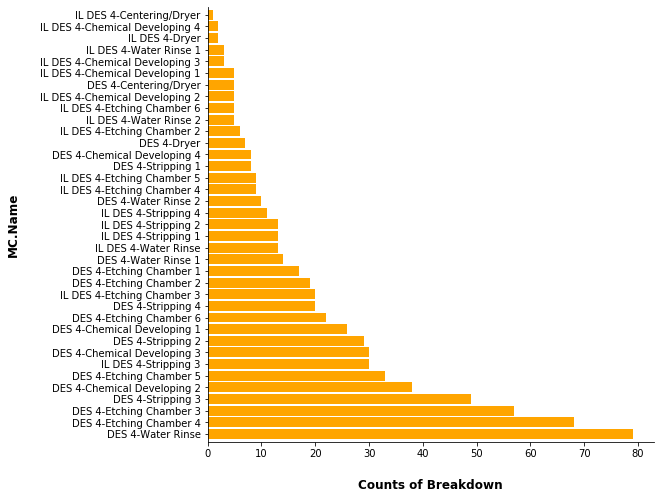

In [19]:
# Check of unique entries of machine names
bx = Final_data['MC.Name '].value_counts().plot(kind='barh', figsize=(8, 8), color='orange', zorder=2, width=0.85)

# Despine
bx.spines['right'].set_visible(False)
bx.spines['top'].set_visible(False)

# Set x-axis label
bx.set_xlabel("Counts of Breakdown", labelpad=20, weight='bold', size=12)

# Set y-axis label
bx.set_ylabel("MC.Name", labelpad=20, weight='bold', size=12)

* Total of 37 unqiue machine names (Chemical line only have 23 modules)
    - Some of unqiue machine names are describing the same items

Text(0, 0.5, 'MC Status When Attend')

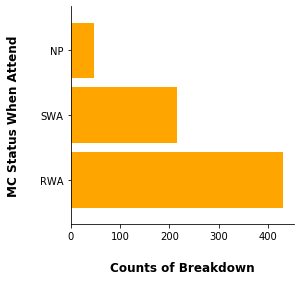

In [20]:
# Check of unique entries of machine status before repair
cx = Final_data['M/C Status When Attend '].value_counts().plot(kind='barh', figsize=(4, 4), color='orange', zorder=2, width=0.85)

# Despine
cx.spines['right'].set_visible(False)
cx.spines['top'].set_visible(False)

# Set x-axis label
cx.set_xlabel("Counts of Breakdown", labelpad=20, weight='bold', size=12)

# Set y-axis label
cx.set_ylabel("MC Status When Attend", labelpad=20, weight='bold', size=12)

* Total of RWA = 431, SWA = 216, NP = 47

Text(0, 0.5, 'MC Status During')

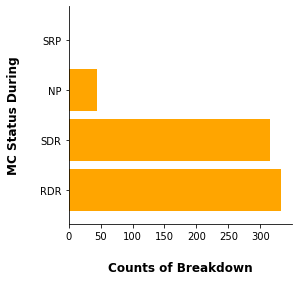

In [21]:
# Check of unique entries of machine status during repair
dx = Final_data['M/C Status During Repair'].value_counts().plot(kind='barh', figsize=(4, 4), color='orange', zorder=2, width=0.85)

# Despine
dx.spines['right'].set_visible(False)
dx.spines['top'].set_visible(False)

# Set x-axis label
dx.set_xlabel("Counts of Breakdown", labelpad=20, weight='bold', size=12)

# Set y-axis label
dx.set_ylabel("MC Status During", labelpad=20, weight='bold', size=12)

* Total of RDR = 333, SDR = 315, NP = 45, SRP = 1

Text(0, 0.5, 'MC Status After')

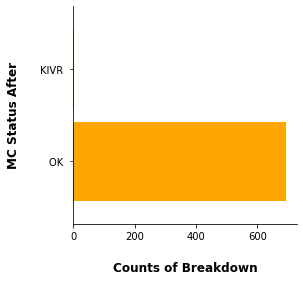

In [22]:
# Check of unique entries of machine status after repair
ex = Final_data['M/C Status After Attend'].value_counts().plot(kind='barh', figsize=(4, 4), color='orange', zorder=2, width=0.85)

# Despine
ex.spines['right'].set_visible(False)
ex.spines['top'].set_visible(False)

# Set x-axis label
ex.set_xlabel("Counts of Breakdown", labelpad=20, weight='bold', size=12)

# Set y-axis label
ex.set_ylabel("MC Status After", labelpad=20, weight='bold', size=12)

* Majority of the repair was successful with 693 breakdowns are OK and 1 breakdown KIV Repair

Text(0, 0.5, 'No of People')

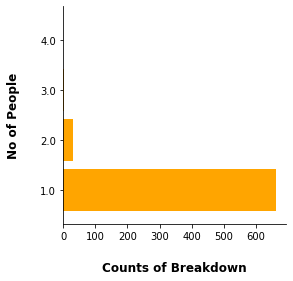

In [23]:
# Check of unique entries of number of people involved in repair
fx = Final_data['No of people attend'].value_counts().plot(kind='barh', figsize=(4, 4), color='orange', zorder=2, width=0.85)

# Despine
fx.spines['right'].set_visible(False)
fx.spines['top'].set_visible(False)

# Set x-axis label
fx.set_xlabel("Counts of Breakdown", labelpad=20, weight='bold', size=12)

# Set y-axis label
fx.set_ylabel("No of People", labelpad=20, weight='bold', size=12)

In [24]:
Final_data['No of people attend'].value_counts()

1.0    661
2.0     30
3.0      2
4.0      1
Name: No of people attend, dtype: int64

* Generally all repairs are done by 1 person, with:
    - 1 person: 661
    - 2 person: 30
    - 3 person: 2
    - 4 person: 1

Text(0, 0.5, 'Breakdown Category')

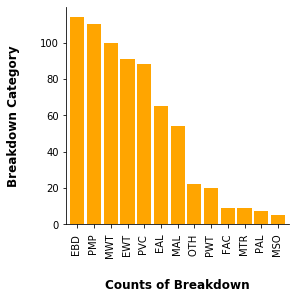

In [25]:
# Check of unique entries of breakdown category
gx = Final_data['Breakdown Repair Category '].value_counts().plot(kind='bar', figsize=(4, 4), color='orange', zorder=2, width=0.85)

# Despine
gx.spines['right'].set_visible(False)
gx.spines['top'].set_visible(False)

# Set x-axis label
gx.set_xlabel("Counts of Breakdown", labelpad=20, weight='bold', size=12)

# Set y-axis label
gx.set_ylabel("Breakdown Category", labelpad=20, weight='bold', size=12)

## 3. Cleaning Up Data (Con't)

In [26]:
# Copy of dataset into another dataframe
ca = Final_data.copy()

In [27]:
# Cleaning up the machine names for the columns
ca.loc[(ca['MC.Name '] == 'DES 4-Water Rinse'), 'MC.Name '] = 'IL DES 4-Water Rinse'
ca.loc[(ca['MC.Name '] == 'DES 4-Etching Chamber 5'), 'MC.Name '] = 'IL DES 4-Etching Chamber 5'
ca.loc[(ca['MC.Name '] == 'DES 4-Etching Chamber 4'), 'MC.Name '] = 'IL DES 4-Etching Chamber 4'
ca.loc[(ca['MC.Name '] == 'DES 4-Etching Chamber 3'), 'MC.Name '] = 'IL DES 4-Etching Chamber 3'
ca.loc[(ca['MC.Name '] == 'DES 4-Stripping 3'), 'MC.Name '] = 'IL DES 4-Stripping 3'
ca.loc[(ca['MC.Name '] == 'DES 4-Chemical Developing 2'), 'MC.Name '] = 'IL DES 4-Chemical Developing 2'
ca.loc[(ca['MC.Name '] == 'DES 4-Chemical Developing 3'), 'MC.Name '] = 'IL DES 4-Chemical Developing 3'
ca.loc[(ca['MC.Name '] == 'DES 4-Stripping 2'), 'MC.Name '] = 'IL DES 4-Stripping 2'
ca.loc[(ca['MC.Name '] == 'DES 4-Stripping 1'), 'MC.Name '] = 'IL DES 4-Stripping 1'
ca.loc[(ca['MC.Name '] == 'DES 4-Stripping 4'), 'MC.Name '] = 'IL DES 4-Stripping 4'
ca.loc[(ca['MC.Name '] == 'DES 4-Chemical Developing 1'), 'MC.Name '] = 'IL DES 4-Chemical Developing 1'
ca.loc[(ca['MC.Name '] == 'DES 4-Chemical Developing 4'), 'MC.Name '] = 'IL DES 4-Chemical Developing 4'
ca.loc[(ca['MC.Name '] == 'DES 4-Etching Chamber 6'), 'MC.Name '] = 'IL DES 4-Etching Chamber 6'
ca.loc[(ca['MC.Name '] == 'DES 4-Etching Chamber 2'), 'MC.Name '] = 'IL DES 4-Etching Chamber 2'
ca.loc[(ca['MC.Name '] == 'DES 4-Etching Chamber 1'), 'MC.Name '] = 'IL DES 4-Etching Chamber 1'
ca.loc[(ca['MC.Name '] == 'DES 4-Water Rinse 1'), 'MC.Name '] = 'IL DES 4-Water Rinse 1'
ca.loc[(ca['MC.Name '] == 'DES 4-Water Rinse 2'), 'MC.Name '] = 'IL DES 4-Water Rinse 2'
ca.loc[(ca['MC.Name '] == 'DES 4-Centering/Dryer'), 'MC.Name '] = 'IL DES 4-Centering/Dryer'
ca.loc[(ca['MC.Name '] == 'DES 4-Dryer'), 'MC.Name '] = 'IL DES 4-Centering/Dryer'
ca.loc[(ca['MC.Name '] == 'IL DES 4-Dryer'), 'MC.Name '] = 'IL DES 4-Centering/Dryer'

# To differentiate between the 2 Water Rinse for the 2 processes
ca.loc[(ca['MC.No '] == 'L112WA'), 'MC.Name '] = 'IL DES 4-Water Rinse (Developing)'
ca.loc[(ca['MC.No '] == 'L127WA'), 'MC.Name '] = 'IL DES 4-Water Rinse (Stripping)'

Text(0, 0.5, 'MC.Name')

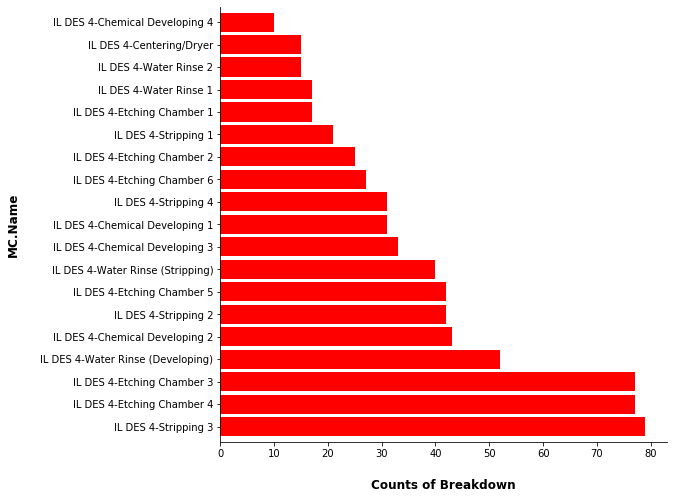

In [28]:
# Check of unique entries of machine names
bx = ca['MC.Name '].value_counts().plot(kind='barh', figsize=(8, 8), color='red', zorder=2, width=0.85)

# Despine
bx.spines['right'].set_visible(False)
bx.spines['top'].set_visible(False)

# Set x-axis label
bx.set_xlabel("Counts of Breakdown", labelpad=20, weight='bold', size=12)

# Set y-axis label
bx.set_ylabel("MC.Name", labelpad=20, weight='bold', size=12)


* Total of 19 unqiue machine names (Chemical line have 23 modules)
    - Modules that are not in database are conveyor roller unit at the front, end and 2 connecting conveyors

In [29]:
# Chck again total number of unique Machine No
ca['MC.No '].nunique()

21

* Total of 19 unique machine names but 21 unique machine no
    - Need to investigate why there's a mismatch:
        Reason is because there are 2 connecting conveyor units that are not correctly named

In [30]:
# First Conveyor Unit (Developing Output Conveyor)
ca[ca['MC.No '] == 'L113CT']

,MC.No,MC.Name,Report Date & Time,Problem Description,M/C Status When Attend,M/C Status During Repair,M/C Status After Attend,No of people attend,Action Taken,Actual Repair Start Time(Attend Date),Troubleshoot Complete Time,Actual Repair Complete Time(Complete Date),Fab/Spare parts sourcing Time(mins),Breakdown Repair Category,KIV Reason,Qty Required,Wait AM/PM,Attend Wait time (mins),Troubleshoot Hours (mins),Rectify Hours (mins),Repair Hours (mins),Repairer 1,Repairer 2
45,L113CT,IL DES 4-Centering/Dryer,2014-05-15 21:05:15,air hose leaking causing high temp.pls check,RWA,RDR,OK,1.0,-trim broken air hose and re-connect.,2014-05-15 21:30:00,2014-05-15 22:00:00,2014-05-15 22:00:00,0.0,PAL,Not Applicable,0.0,PM,25.0,30.0,0.0,30.0,DENNIS DAUZ (MN),No Repairer 2
540,L113CT,IL DES 4-Centering/Dryer,2018-12-06 23:08:06,leaking water,SWA,SDR,OK,2.0,-clear choke pipe.,2018-12-07 00:30:00,2018-12-07 01:00:00,2018-12-07 01:00:00,0.0,PVC,Not Applicable,0.0,PM,82.0,30.0,0.0,30.0,DENNIS DAUZ (MN)/JERSON,No Repairer 2


In [31]:
# Second Conveyor Unit (Etching Output Conveyor)
ca[ca['MC.No '] == 'L122CT']

,MC.No,MC.Name,Report Date & Time,Problem Description,M/C Status When Attend,M/C Status During Repair,M/C Status After Attend,No of people attend,Action Taken,Actual Repair Start Time(Attend Date),Troubleshoot Complete Time,Actual Repair Complete Time(Complete Date),Fab/Spare parts sourcing Time(mins),Breakdown Repair Category,KIV Reason,Qty Required,Wait AM/PM,Attend Wait time (mins),Troubleshoot Hours (mins),Rectify Hours (mins),Repair Hours (mins),Repairer 1,Repairer 2
105,L122CT,IL DES 4-Centering/Dryer,2014-01-17 09:45:00,emergency button spoil,RWA,SDR,OK,1.0,replace the button,2014-01-17 11:30:00,2014-01-17 12:25:00,2014-01-17 12:25:00,0.0,EWT,Not Applicable,0.0,AM,105.0,55.0,0.0,55.0,LI YONGXIN (MN),No Repairer 2
106,L122CT,IL DES 4-Centering/Dryer,2014-08-05 05:31:23,water pipe leaking pls check,RWA,RDR,OK,1.0,check and repair leaking piping,2014-08-19 07:00:00,2014-08-19 07:05:00,2014-08-19 07:10:00,0.0,PVC,Not Applicable,0.0,PM,20249.0,5.0,5.0,10.0,JERSON CASTRO (MN),No Repairer 2
398,L122CT,IL DES 4-Centering/Dryer,2016-12-06 05:06:06,stripping pump problem,SWA,SDR,OK,1.0,Found the pump cover dropped . Bolts are missi...,2016-12-06 05:15:00,2016-12-06 07:00:00,2016-12-06 07:00:00,15.0,PMP,Not Applicable,0.0,PM,9.0,105.0,0.0,105.0,ALEXANDER ROSARIO (MN),No Repairer 2
503,L122CT,IL DES 4-Centering/Dryer,2017-10-06 23:07:36,l4 shoubanji mo working,RWA,SDR,OK,1.0,check found interleave arm can not origin due ...,2017-10-07 02:00:00,2017-10-07 04:00:00,2017-10-07 04:00:00,0.0,EWT,Not Applicable,0.0,PM,173.0,120.0,0.0,120.0,JERSON CASTRO (MN),No Repairer 2


In [32]:
# Update 2 modules with correct machine name
ca.loc[(ca['MC.No '] == 'L113CT'), 'MC.Name '] = 'IL DES 4-Developing Output Conveyor'
ca.loc[(ca['MC.No '] == 'L122CT'), 'MC.Name '] = 'IL DES 4-Etching Output Conveyor'

Text(0.5, 1.0, 'Breakdown Location Distribution')

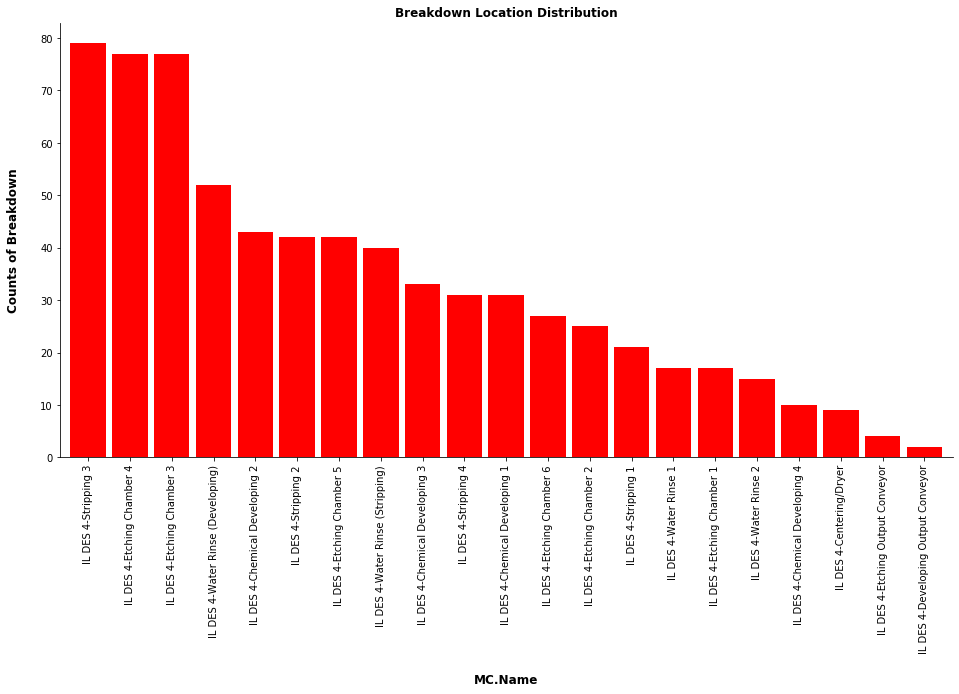

In [33]:
# Check of unique entries of machine names
bx = ca['MC.Name '].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(16, 8), color='red', zorder=2, width=0.85)

# Despine
bx.spines['right'].set_visible(False)
bx.spines['top'].set_visible(False)

# Set x-axis label
bx.set_xlabel("MC.Name", labelpad=20, weight='bold', size=12)

# Set y-axis label
bx.set_ylabel("Counts of Breakdown", labelpad=20, weight='bold', size=12)

bx.set_title("Breakdown Location Distribution", weight='bold')

* Now both the Machine No and Machine Name are equal with 21 unqiue values

In [34]:
# All repairers in the maintenance record for chemical line
ca['Repairer 1'].value_counts().to_frame()

,Repairer 1
LI YONGXIN (MN),301
JERSON CASTRO (MN),110
DENNIS DAUZ (MN),45
ALEXANDER ROSARIO (MN),32
REY MASONGSONG (MN),29
...,...
LI YONGXIN (MN,1
PAOLO/RANDY(MN),1
JERSON CASTRO (MN)freddix,1
NORWAY R ROTAZO (MN) dennis,1


In [35]:
# Simplifying and managing duplicates of repairers' names, assuming those with names with / we only take first name
wa = ca.copy()
wa['Repairer 1'].astype(str)
wa['Repairer 1'] = wa['Repairer 1'].str.lower()



za = wa['Repairer 1'].str.replace('[,,/,-,(]', ' ')
za = za.str.strip(' ').str.split(' ', expand=True).add_prefix('repairer')
za = za['repairer0'].to_frame()
za['repairer0'].value_counts()

ca['Repairer Name'] = za
final_ca = ca.drop(columns = ['Repairer 1', 'Repairer 2'])
final_ca

,MC.No,MC.Name,Report Date & Time,Problem Description,M/C Status When Attend,M/C Status During Repair,M/C Status After Attend,No of people attend,Action Taken,Actual Repair Start Time(Attend Date),Troubleshoot Complete Time,Actual Repair Complete Time(Complete Date),Fab/Spare parts sourcing Time(mins),Breakdown Repair Category,KIV Reason,Qty Required,Wait AM/PM,Attend Wait time (mins),Troubleshoot Hours (mins),Rectify Hours (mins),Repair Hours (mins),Repairer Name
0,L108DV,IL DES 4-Chemical Developing 1,2014-02-20 03:55:15,few rollers with loose 'o' ring causing pnl ov...,SWA,SDR,OK,1.0,replace some worn out oring @ develoving roller,2014-02-20 04:00:00,2014-02-20 04:35:00,2014-02-20 04:35:00,0.0,MWT,Not Applicable,0.0,PM,5.0,35.0,0.0,35.0,jerson
1,L108DV,IL DES 4-Chemical Developing 1,2014-02-26 16:53:06,dev system level sensor data jammed...chemical...,SWA,SDR,OK,1.0,clean sensor and reset system.,2014-02-26 17:00:00,2014-02-26 17:50:00,2014-02-26 17:50:00,0.0,EBD,Not Applicable,0.0,AM,7.0,50.0,0.0,50.0,li
2,L108DV,IL DES 4-Chemical Developing 1,2014-03-31 05:12:26,filter pipe leaking,NP,NP,OK,1.0,replace the pvc filter connector.,2014-03-31 05:30:00,2014-03-31 06:00:00,2014-03-31 06:00:00,0.0,PVC,Not Applicable,0.0,PM,18.0,30.0,0.0,30.0,jerson
3,L108DV,IL DES 4-Chemical Developing 1,2014-04-28 20:47:53,air hose leaking,RWA,RDR,OK,1.0,-trim and re-connect broken airhose.,2014-04-28 21:00:00,2014-04-28 21:15:00,2014-04-28 21:15:00,0.0,PWT,Not Applicable,0.0,PM,13.0,15.0,0.0,15.0,dennis
4,L108DV,IL DES 4-Chemical Developing 1,2014-05-19 14:04:31,air leakage,RWA,RDR,OK,1.0,replace air connector.,2014-05-19 14:40:00,2014-05-19 15:00:00,2014-05-19 15:00:00,0.0,PWT,Not Applicable,0.0,AM,36.0,20.0,0.0,20.0,li
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,L127WA,IL DES 4-Water Rinse (Stripping),2019-03-13 08:58:51,water pipe leaking...pls come check thx,RWA,RDR,OK,1.0,replace the water flow meter.,2019-03-13 09:00:00,2019-03-13 09:30:00,2019-03-13 09:30:00,0.0,MAL,Not Applicable,0.0,AM,2.0,30.0,0.0,30.0,li
696,L127WA,IL DES 4-Water Rinse (Stripping),2019-06-02 20:24:26,water pipe leaking,SWA,SDR,OK,1.0,check found flow meter glass clip already spoi...,2019-06-02 22:00:00,2019-06-02 23:20:00,2019-06-02 23:20:00,0.0,MWT,Not Applicable,0.0,PM,96.0,80.0,0.0,80.0,jerson
697,L127WA,IL DES 4-Water Rinse (Stripping),2019-07-09 12:51:10,new water pump trip come to check thx,RWA,RDR,OK,1.0,replace the pump,2019-07-09 14:00:00,2019-07-09 15:00:00,2019-07-09 15:00:00,0.0,PMP,Not Applicable,0.0,AM,69.0,60.0,0.0,60.0,li
698,L127WA,IL DES 4-Water Rinse (Stripping),2019-07-16 14:33:48,new water pipe leaking...pls come to check thx,RWA,RDR,OK,1.0,tighten the flow meter.,2019-07-16 16:00:00,2019-07-16 16:20:00,2019-07-16 16:20:00,0.0,PVC,Not Applicable,0.0,AM,87.0,20.0,0.0,20.0,li


## 4. Exploratory Data Analysis (EDA)

* Comparison of Columns:

#01 : Breakdown Category Distribution
#02 : Years vs Breakdown Category
#03 : Breakdown Category vs Process
#04 : Years vs Top 3 Breakdown Cateogry
#05 : Month vs Top 3 Breakdown Cateogry
#06 : Machine No vs Top 3 Breakdown Cateogry
#07 : Breakdown Category vs Troubleshooting Time
#08 : Breakdown Category vs Repair Time
#09 : Top 10 counts of entries/repairs done by each repairer
#10 : Repairer vs Troubleshooting Time
#11 : Repairer vs Repair Time
#12 : Average Troubleshooting Time of Repairers based on Breakdown Repair Category
#13 : Average Repair Time of Repairers based on Breakdown Repair Category
#14 : Top 10 Repairer with Most Repair Skills
#15 : Top Repairer Average Troubleshooting Time vs Top 3 Breakdown Categories
#16 : Top Repairer Average Repair Time vs Top 3 Breakdown Categories

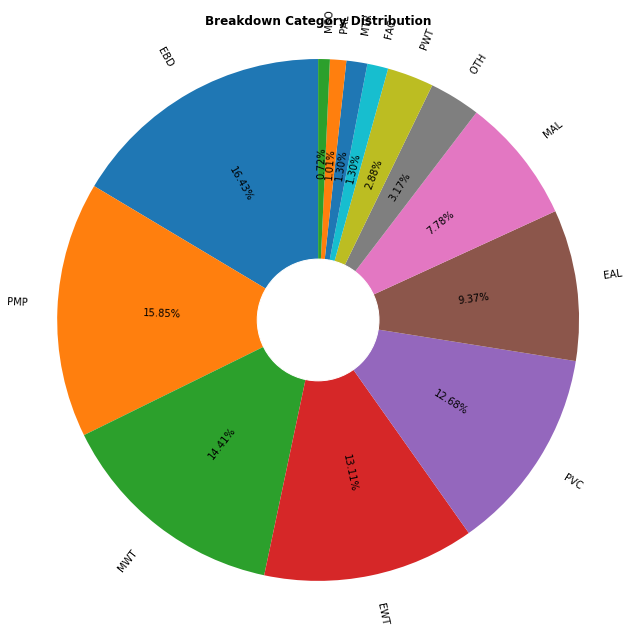

In [36]:
#01 Years vs Breakdown Category (Check of unique entries of breakdown category)

gx = Final_data['Breakdown Repair Category '].value_counts()
patches, labels, pct_texts = plt.pie(gx, labels= gx.index, startangle=90, autopct='%1.2f%%', rotatelabels=True, radius = 3)

for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())

#gx.set_title("Breakdown Repair Category Distribution", weight='bold', size=16)
#figsize=(8, 8), 
#plt.rcParams.update({'font.size': 14})


my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Breakdown Category Distribution\n\n\n\n\n\n\n\n\n\n\n\n", weight='bold')
plt.show()

In [37]:
Final_data['Breakdown Repair Category '].value_counts().to_frame()

,Breakdown Repair Category
EBD,114
PMP,110
MWT,100
EWT,91
PVC,88
EAL,65
MAL,54
OTH,22
PWT,20
FAC,9


* The breakdown of the breakdown repair category are:
    - EBD:     114
    - PMP:     110
    - MWT:     100
    - EWT:      91
    - PVC:      88
    - EAL:      65
    - MAL:      54
    - OTH:      22
    - PWT:      20
    - FAC:       9
    - MTR:       9
    - PAL:       7
    - MSO:       5

In [38]:
# Tag the process of the different machines
final_ca["Process"] = final_ca["MC.Name "]

# renaming all "Water Rinse" machines to "Water Rinse"
final_ca["Process"] = final_ca["Process"].str.replace(r'(^.*Water.*$)', 'Water Rinse')

# renaming all "Etching Chamber" machines to "Etching Chamber"
final_ca["Process"] = final_ca["Process"].str.replace(r'(^.*Etching.*$)', 'Etching Chamber')

# renaming all "Stripping" machines to "Stripping"
final_ca["Process"] = final_ca["Process"].str.replace(r'(^.*Stripping.*$)', 'Stripping')

# renaming all "Chemical Developing" machines to "Developing"
final_ca["Process"] = final_ca["Process"].str.replace(r'(^.*Chemical.*$)', 'Developing')

# renaming all "Dryer" machines to "Dryer"
final_ca["Process"] = final_ca["Process"].str.replace(r'(^.*Dryer.*$)', 'Dryer')

# renaming all "Conveyor" machines to "Conveyor"
final_ca["Process"] = final_ca["Process"].str.replace(r'(^.*Conveyor.*$)', 'Conveyor')

# Extract the Year and Month into separate columns
final_ca['Year'] = pd.DatetimeIndex(ca['Report Date & Time']).year
final_ca['Month'] = pd.DatetimeIndex(ca['Report Date & Time']).month
final_ca

,MC.No,MC.Name,Report Date & Time,Problem Description,M/C Status When Attend,M/C Status During Repair,M/C Status After Attend,No of people attend,Action Taken,Actual Repair Start Time(Attend Date),Troubleshoot Complete Time,Actual Repair Complete Time(Complete Date),Fab/Spare parts sourcing Time(mins),Breakdown Repair Category,KIV Reason,Qty Required,Wait AM/PM,Attend Wait time (mins),Troubleshoot Hours (mins),Rectify Hours (mins),Repair Hours (mins),Repairer Name,Process,Year,Month
0,L108DV,IL DES 4-Chemical Developing 1,2014-02-20 03:55:15,few rollers with loose 'o' ring causing pnl ov...,SWA,SDR,OK,1.0,replace some worn out oring @ develoving roller,2014-02-20 04:00:00,2014-02-20 04:35:00,2014-02-20 04:35:00,0.0,MWT,Not Applicable,0.0,PM,5.0,35.0,0.0,35.0,jerson,Developing,2014,2
1,L108DV,IL DES 4-Chemical Developing 1,2014-02-26 16:53:06,dev system level sensor data jammed...chemical...,SWA,SDR,OK,1.0,clean sensor and reset system.,2014-02-26 17:00:00,2014-02-26 17:50:00,2014-02-26 17:50:00,0.0,EBD,Not Applicable,0.0,AM,7.0,50.0,0.0,50.0,li,Developing,2014,2
2,L108DV,IL DES 4-Chemical Developing 1,2014-03-31 05:12:26,filter pipe leaking,NP,NP,OK,1.0,replace the pvc filter connector.,2014-03-31 05:30:00,2014-03-31 06:00:00,2014-03-31 06:00:00,0.0,PVC,Not Applicable,0.0,PM,18.0,30.0,0.0,30.0,jerson,Developing,2014,3
3,L108DV,IL DES 4-Chemical Developing 1,2014-04-28 20:47:53,air hose leaking,RWA,RDR,OK,1.0,-trim and re-connect broken airhose.,2014-04-28 21:00:00,2014-04-28 21:15:00,2014-04-28 21:15:00,0.0,PWT,Not Applicable,0.0,PM,13.0,15.0,0.0,15.0,dennis,Developing,2014,4
4,L108DV,IL DES 4-Chemical Developing 1,2014-05-19 14:04:31,air leakage,RWA,RDR,OK,1.0,replace air connector.,2014-05-19 14:40:00,2014-05-19 15:00:00,2014-05-19 15:00:00,0.0,PWT,Not Applicable,0.0,AM,36.0,20.0,0.0,20.0,li,Developing,2014,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,L127WA,IL DES 4-Water Rinse (Stripping),2019-03-13 08:58:51,water pipe leaking...pls come check thx,RWA,RDR,OK,1.0,replace the water flow meter.,2019-03-13 09:00:00,2019-03-13 09:30:00,2019-03-13 09:30:00,0.0,MAL,Not Applicable,0.0,AM,2.0,30.0,0.0,30.0,li,Water Rinse,2019,3
696,L127WA,IL DES 4-Water Rinse (Stripping),2019-06-02 20:24:26,water pipe leaking,SWA,SDR,OK,1.0,check found flow meter glass clip already spoi...,2019-06-02 22:00:00,2019-06-02 23:20:00,2019-06-02 23:20:00,0.0,MWT,Not Applicable,0.0,PM,96.0,80.0,0.0,80.0,jerson,Water Rinse,2019,6
697,L127WA,IL DES 4-Water Rinse (Stripping),2019-07-09 12:51:10,new water pump trip come to check thx,RWA,RDR,OK,1.0,replace the pump,2019-07-09 14:00:00,2019-07-09 15:00:00,2019-07-09 15:00:00,0.0,PMP,Not Applicable,0.0,AM,69.0,60.0,0.0,60.0,li,Water Rinse,2019,7
698,L127WA,IL DES 4-Water Rinse (Stripping),2019-07-16 14:33:48,new water pipe leaking...pls come to check thx,RWA,RDR,OK,1.0,tighten the flow meter.,2019-07-16 16:00:00,2019-07-16 16:20:00,2019-07-16 16:20:00,0.0,PVC,Not Applicable,0.0,AM,87.0,20.0,0.0,20.0,li,Water Rinse,2019,7


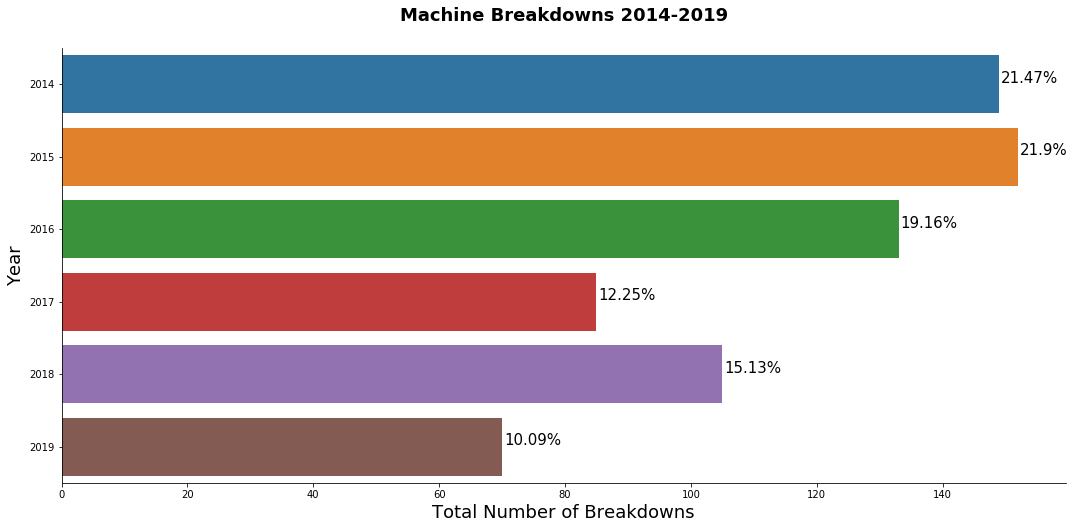

In [39]:
#02 Years vs Breakdown Category (Overview Visualization of Machine Breakdowns by Years)

f, ax = plt.subplots(figsize=(18, 8))

ax = sns.countplot(y="Year", data=final_ca)
plt.xlabel("Total Number of Breakdowns", fontsize=18)
plt.ylabel("Year", fontsize=18)
plt.title("Machine Breakdowns 2014-2019\n", weight='bold', fontsize=18)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='black')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

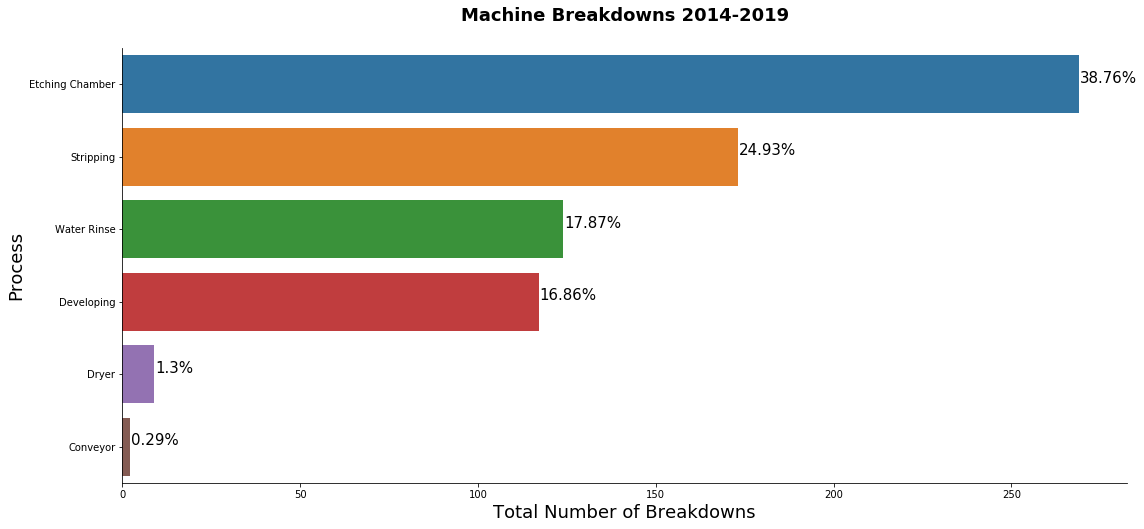

In [40]:
#03 Breakdown Category vs Process (Overview Visualization of Machine Breakdowns by Years)

f, ax = plt.subplots(figsize=(18, 8))
ax = sns.countplot(y="Process", data=final_ca, order=final_ca["Process"].value_counts().index)

plt.xlabel("Total Number of Breakdowns", fontsize=18)
plt.ylabel("Process", fontsize=18)
plt.title("Machine Breakdowns 2014-2019\n", weight='bold', fontsize=18)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='black')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Text(0.5, 1.0, 'Top Breakdown Over the Years')

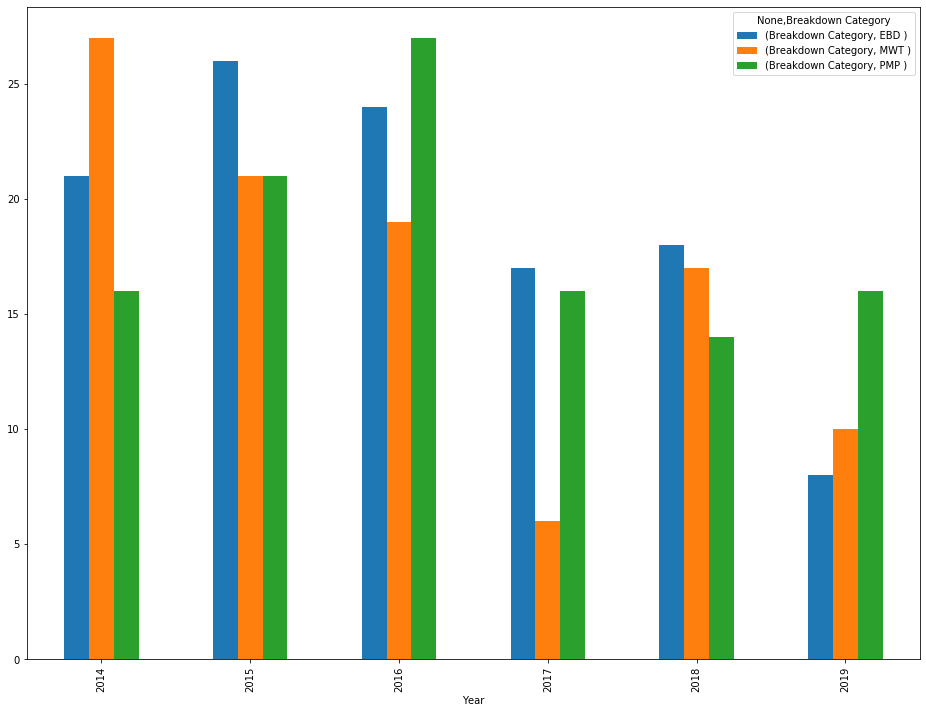

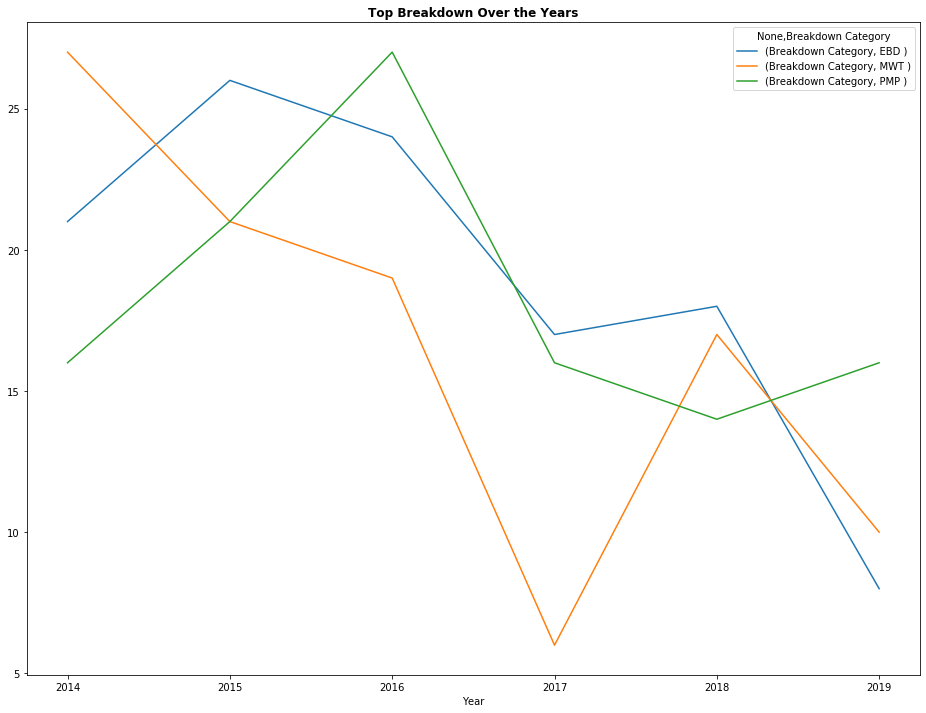

In [41]:
#04 : Years vs Top 3 Breakdown Cateogry

top_breakdowns = ['EBD ', 'PMP ', 'MWT ']

comparison_1 = {'Year': [], 'Breakdown Category': []}
comparison_1['Year'] = final_ca['Year']
comparison_1['Breakdown Category'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(top_breakdowns)]
comparison_1 = pd.DataFrame(comparison_1)
comparison_1 = comparison_1.groupby('Year')['Breakdown Category'].value_counts()
comparison_1 = comparison_1.groupby('Year').head(5)

# Check each unique entries of breakdown category over the years
hx = comparison_1
#hx = comparison_3.plot(kind='bar', figsize=(10, 20), zorder=2, width=0.85)
hx = pd.DataFrame(hx)
hx

#hx.groupby(['Machine No']).plot.bar(stacked=True)
hx.unstack().plot.bar(figsize=(16, 12), legend = True) # use line chart
hx.unstack().plot.line(figsize=(16, 12), legend = True) # use line chart
hx.unstack()


plt.title('Top Breakdown Over the Years',  weight='bold')

#hx = comparison_1.groupby(['Year'])['Breakdown Category'].size().plot(kind='bar', figsize=(8, 8), color='red', zorder=2, width=0.85)

    Year Breakdown Category  Count
0   2014               MWT      27
1   2014               EBD      21
2   2014               PMP      16
3   2015               EBD      26
4   2015               MWT      21
5   2015               PMP      21
6   2016               PMP      27
7   2016               EBD      24
8   2016               MWT      19
9   2017               EBD      17
10  2017               PMP      16
11  2017               MWT       6
12  2018               EBD      18
13  2018               MWT      17
14  2018               PMP      14
15  2019               PMP      16
16  2019               MWT      10
17  2019               EBD       8


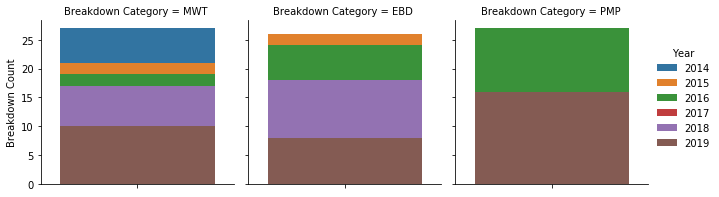

In [42]:
comparison_1 = {'Year': [], 'Breakdown Category': []}
comparison_1['Year'] = final_ca['Year']
comparison_1['Breakdown Category'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(top_breakdowns)]
comparison_1 = pd.DataFrame(comparison_1)
comparison_1 = comparison_1.groupby('Year')['Breakdown Category'].value_counts()
comparison_1 = comparison_1.groupby('Year').head(5)
df = pd.DataFrame(comparison_1).rename(columns={'Breakdown Category':'Count'})
df = df.reset_index()
print(df)

f = sns.FacetGrid(df, col='Breakdown Category', hue='Year', col_wrap=3)
f.map_dataframe(sns.barplot, x= 'Breakdown Category', y= 'Count', data= df)
f.set_axis_labels('', 'Breakdown Count')
f.add_legend()
f.set(xticklabels=[])



Text(0.5, 1.0, 'Top Breakdown Over the Months')

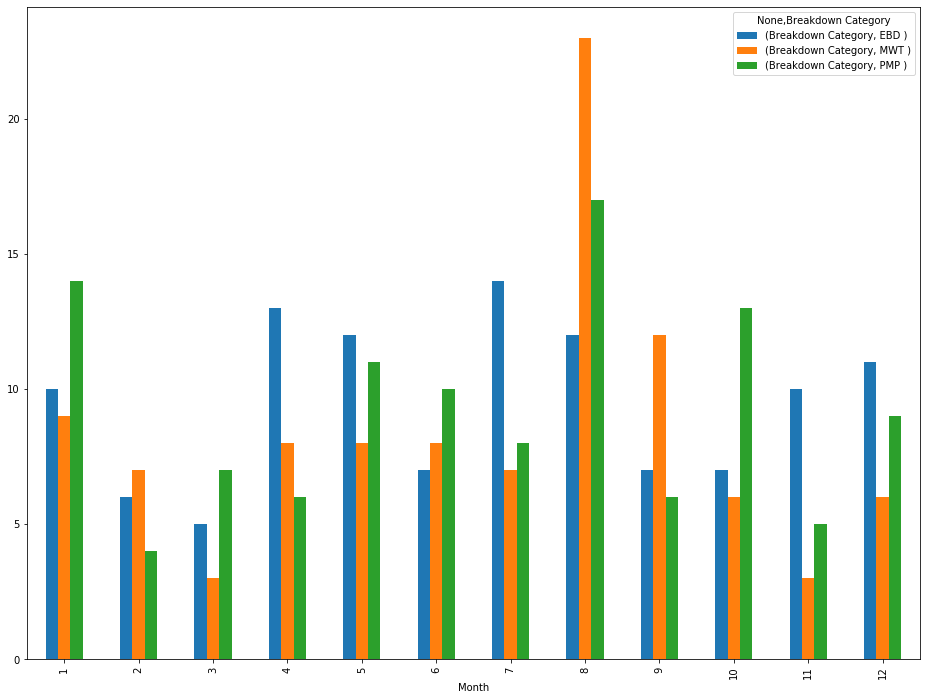

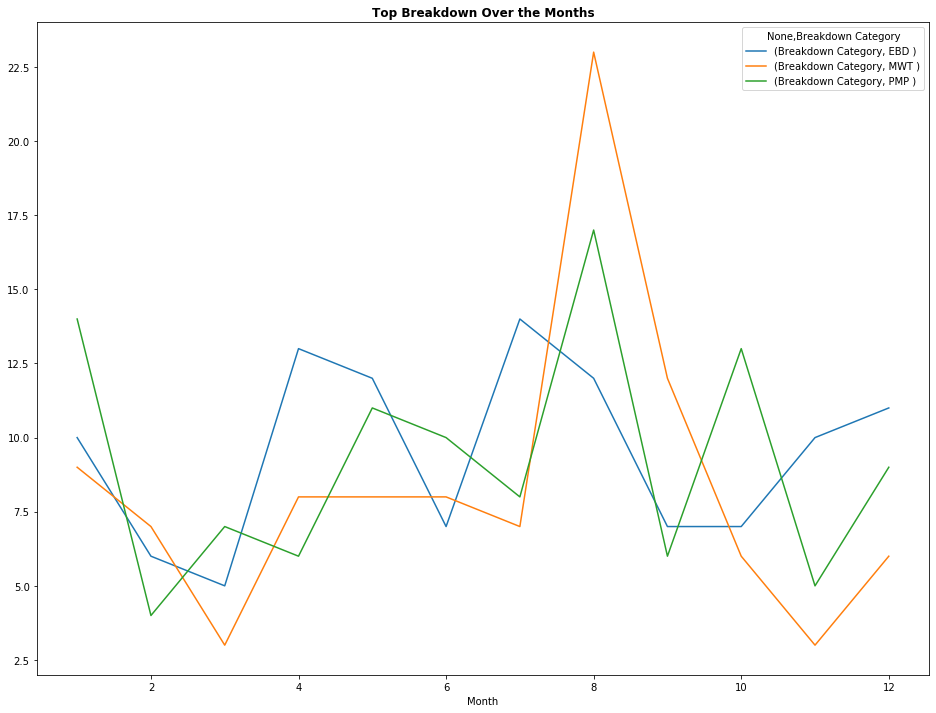

In [43]:
#05 : Month vs Top 3 Breakdown Cateogry
top_breakdowns = ['EBD ', 'PMP ', 'MWT ']

comparison_2 = {'Month': [], 'Breakdown Category': []}
comparison_2['Month'] = final_ca['Month']
comparison_2['Breakdown Category'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(top_breakdowns)]
comparison_2 = pd.DataFrame(comparison_2)
comparison_2 = comparison_2.groupby('Month')['Breakdown Category'].value_counts()
comparison_2 = comparison_2.groupby('Month').head(3)

# Check each unique entries of breakdown category occurs by months
hx = comparison_2
#hx = comparison_3.plot(kind='bar', figsize=(10, 20), zorder=2, width=0.85)
hx = pd.DataFrame(hx)
hx

#hx.groupby(['Machine No']).plot.bar(stacked=True)
hx.unstack().plot.bar(figsize=(16, 12), legend = True)
hx.unstack().plot.line(figsize=(16, 12), legend = True)
hx.unstack() 

plt.title('Top Breakdown Over the Months', weight='bold')

Month
8     52
1     33
5     31
7     29
4     27
12    26
10    26
9     25
6     25
11    18
2     17
3     15
Name: Count, dtype: int64


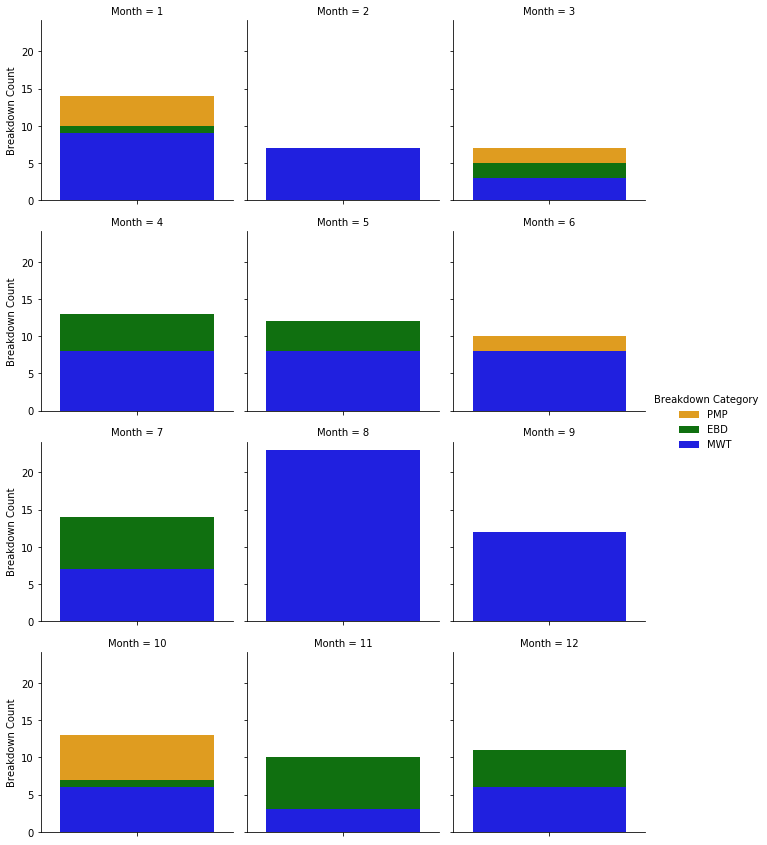

In [44]:
top_breakdowns = ['EBD ', 'PMP ', 'MWT ']

comparison_2 = {'Month': [], 'Breakdown Category': []}
comparison_2['Month'] = final_ca['Month']
comparison_2['Breakdown Category'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(top_breakdowns)]
comparison_2 = pd.DataFrame(comparison_2)
comparison_2 = comparison_2.groupby('Month')['Breakdown Category'].value_counts()
comparison_2 = comparison_2.groupby('Month').head(3)
df2 = pd.DataFrame(comparison_2).rename(columns={'Breakdown Category':'Count'})
df2 = df2.reset_index()
print(df2.groupby('Month')['Count'].sum().sort_values(ascending= False))

colors = ["Orange", "Green", "Blue"]
sns.set_palette(sns.color_palette(colors))

g = sns.FacetGrid(df2, col='Month', hue='Breakdown Category', col_wrap=3)
g.map_dataframe(sns.barplot, x= 'Breakdown Category', y= 'Count', data= df2)
g.set_axis_labels('', 'Breakdown Count')
g.add_legend()
g.set(xticklabels=[])

plt.show()

Breakdown Category            
Breakdown Category               EBD   MWT   PMP 
Machine No                                       
L108DV                            7.0   7.0   2.0
L109DV                           16.0   3.0   2.0
L110DV                           14.0   4.0   1.0
L111DV                            1.0   1.0   NaN
L112WA                            7.0   9.0  16.0
L114ET                            5.0   1.0   1.0
L115ET                            4.0   4.0   4.0
L116ET                           11.0  11.0  12.0
L117ET                           10.0   7.0  13.0
L118ET                           10.0   2.0   3.0
L119ET                            5.0   NaN   9.0
L120WA                            1.0   3.0   5.0
L121WA                            1.0   4.0   3.0
L122CT                            NaN   NaN   1.0
L123ST                            5.0   2.0   4.0
L124ST                            4.0  12.0   5.0
L125ST                           11.0  13.0  13.0
L126ST                            1.0   5.0   7.0
L127WA                            1.0   9.0   9.0
L128DR                            NaN   3.0   NaN

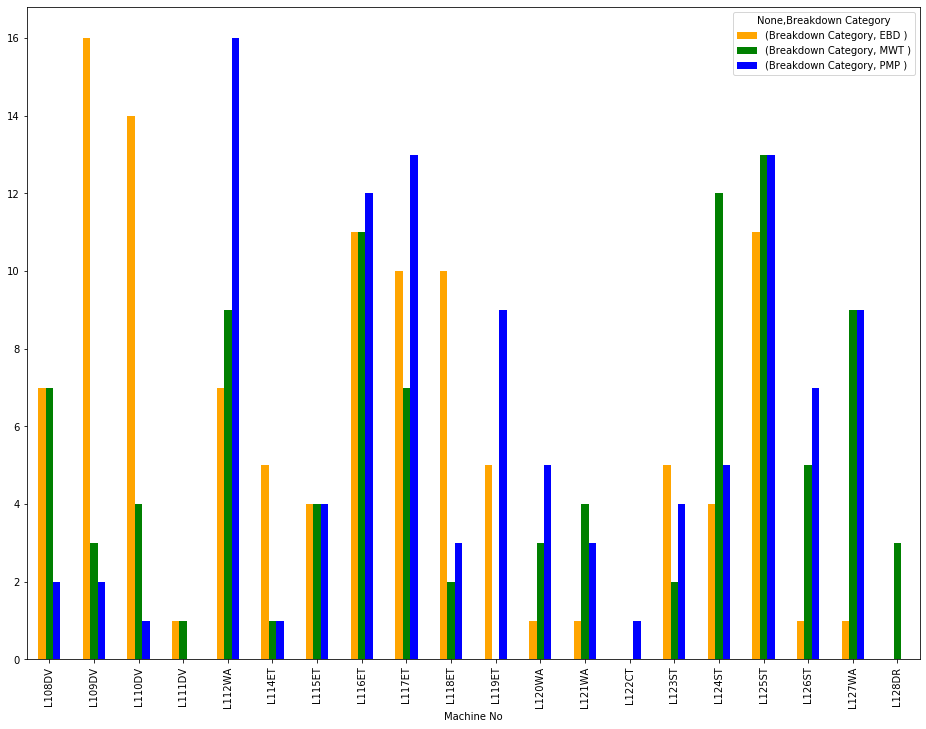

In [45]:
#06 : Machine No vs Number of Breakdown Cateogry

top_breakdowns = ['EBD ', 'PMP ', 'MWT ']

# Create a dataframe for comparison #3
comparison_3 = {'Machine No': [], 'Breakdown Category': []}
comparison_3['Machine No'] = final_ca['MC.No ']
comparison_3['Breakdown Category'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(top_breakdowns)]
comparison_3 = pd.DataFrame(comparison_3)
comparison_3 = comparison_3.groupby('Machine No')['Breakdown Category'].value_counts()
comparison_3 = comparison_3.groupby('Machine No').head(3)

# Check of no of people required for each unique entries of breakdown category
hx = comparison_3
#hx = comparison_3.plot(kind='bar', figsize=(8, 8), zorder=2, width=0.85)
hx = pd.DataFrame(hx)
hx

#hx.groupby(['Machine No']).plot.bar(stacked=True)
hx.unstack().plot.bar(figsize=(16, 12), legend = True)
hx.unstack()


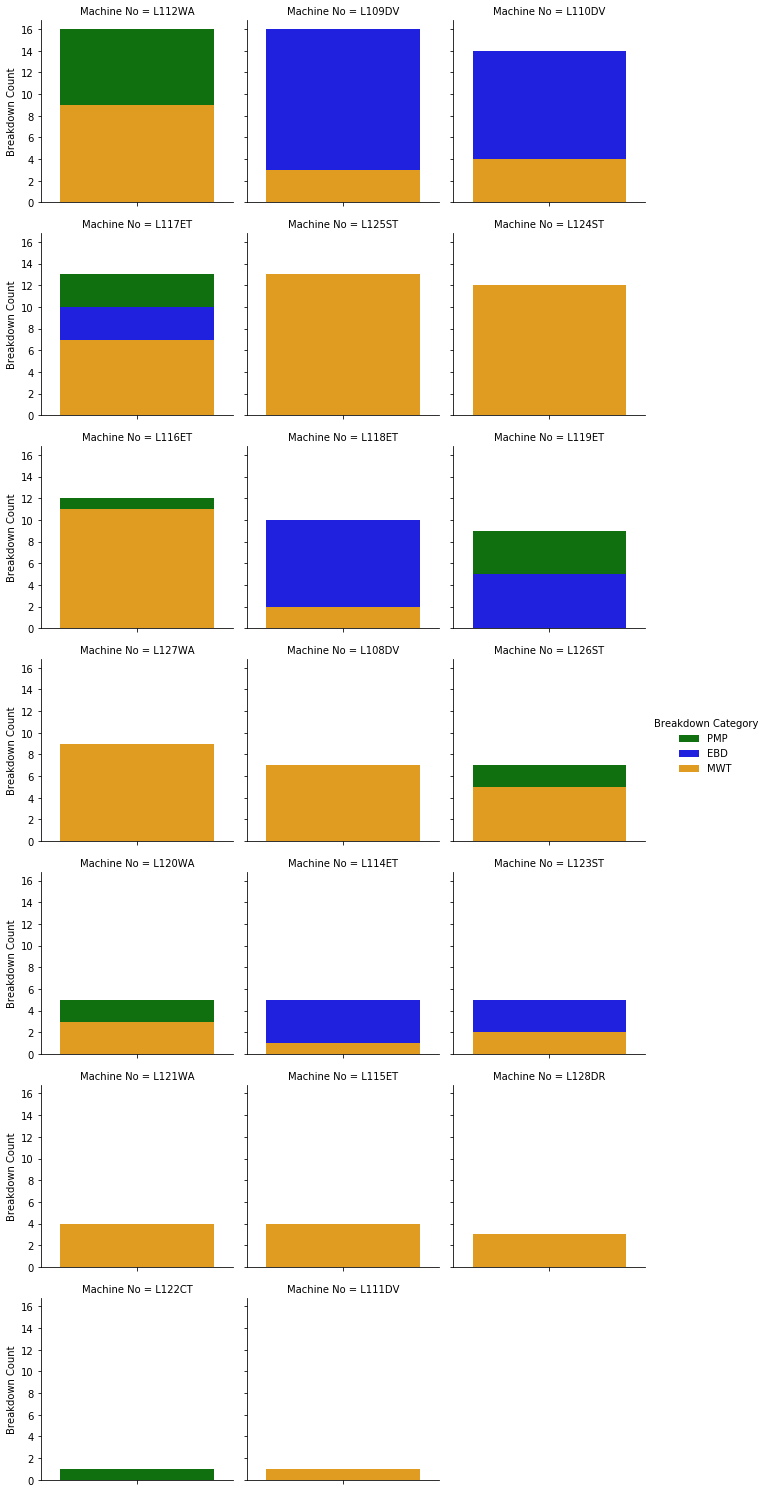

In [46]:
top_breakdowns = ['EBD ', 'PMP ', 'MWT ']

comparison_3 = {'Machine No': [], 'Breakdown Category': []}
comparison_3['Machine No'] = final_ca['MC.No ']
comparison_3['Breakdown Category'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(top_breakdowns)]
comparison_3 = pd.DataFrame(comparison_3)
comparison_3 = comparison_3.groupby('Machine No')['Breakdown Category'].value_counts().sort_values(ascending= False)
#comparison_3 = comparison_3.groupby('Machine No').head(3)
df3 = pd.DataFrame(comparison_3).rename(columns={'Breakdown Category':'Count'})
df3 = df3.reset_index()
#print(df3)


colors = ["Green", "Blue", "Orange"]
sns.set_palette(sns.color_palette(colors))

g = sns.FacetGrid(df3, col='Machine No', hue='Breakdown Category', col_wrap=3)
g.map_dataframe(sns.barplot, x= 'Breakdown Category', y= 'Count', data= df)
g.set_axis_labels('', 'Breakdown Count')
g.add_legend()
g.set(xticklabels=[])

Text(0.5, 0.98, 'EBD Breakdown - Top 3 Modules')

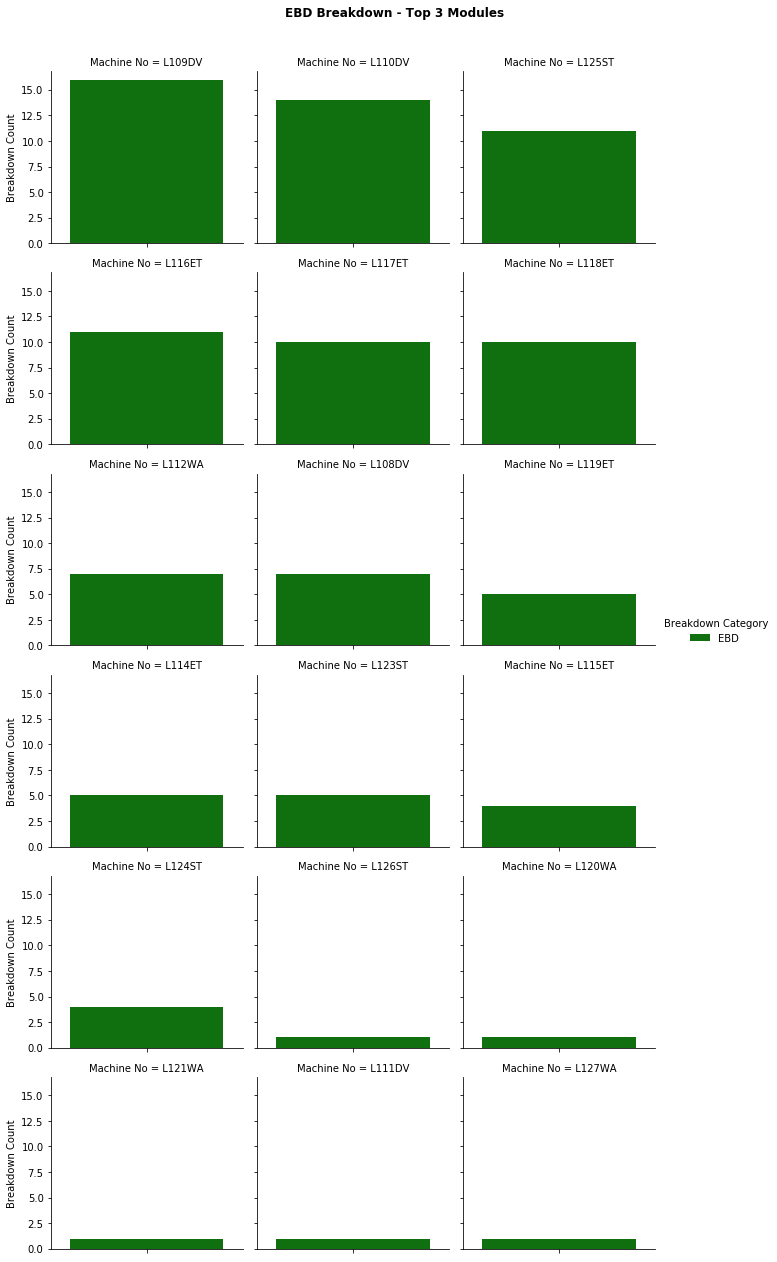

In [47]:
#top_breakdowns = ['EBD ', 'PMP ', 'MWT ']
topone_breakdowns = ['EBD ']

comparison_3 = {'Machine No': [], 'Breakdown Category': []}
comparison_3['Machine No'] = final_ca['MC.No ']
comparison_3['Breakdown Category'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(topone_breakdowns)]
comparison_3 = pd.DataFrame(comparison_3)
comparison_3 = comparison_3.groupby('Machine No')['Breakdown Category'].value_counts().sort_values(ascending= False)
comparison_3 = comparison_3.groupby('Machine No').head(3)
df3 = pd.DataFrame(comparison_3).rename(columns={'Breakdown Category':'Count'})
df3 = df3.reset_index()
#print(df3)


g = sns.FacetGrid(df3, col='Machine No', hue='Breakdown Category', col_wrap=3)
g.map_dataframe(sns.barplot, x= 'Breakdown Category', y= 'Count', data= df)
g.set_axis_labels('', 'Breakdown Count')
g.add_legend()
g.set(xticklabels=[])

plt.subplots_adjust(top=0.93)
g.fig.suptitle("EBD Breakdown - Top 3 Modules", weight='bold')

Text(0.5, 0.98, 'PMP Breakdown - Top 3 Modules')

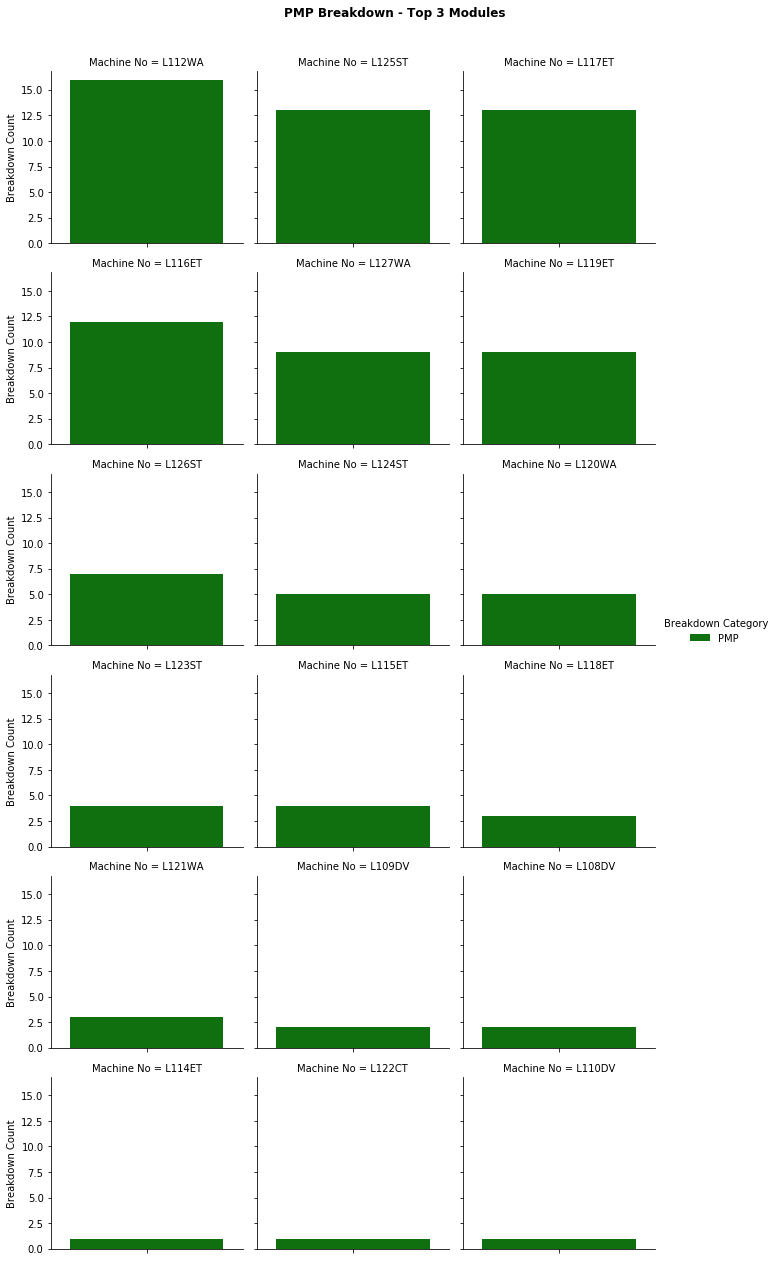

In [48]:
#top_breakdowns = ['EBD ', 'PMP ', 'MWT ']
topone_breakdowns = ['PMP ']

comparison_3 = {'Machine No': [], 'Breakdown Category': []}
comparison_3['Machine No'] = final_ca['MC.No ']
comparison_3['Breakdown Category'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(topone_breakdowns)]
comparison_3 = pd.DataFrame(comparison_3)
comparison_3 = comparison_3.groupby('Machine No')['Breakdown Category'].value_counts().sort_values(ascending= False)
comparison_3 = comparison_3.groupby('Machine No').head(3)
df3 = pd.DataFrame(comparison_3).rename(columns={'Breakdown Category':'Count'})
df3 = df3.reset_index()
#print(df3)


g = sns.FacetGrid(df3, col='Machine No', hue='Breakdown Category', col_wrap=3)
g.map_dataframe(sns.barplot, x= 'Breakdown Category', y= 'Count', data= df, color= 'Green')
g.set_axis_labels('', 'Breakdown Count')
g.add_legend()
g.set(xticklabels=[])

plt.subplots_adjust(top=0.93)
g.fig.suptitle("PMP Breakdown - Top 3 Modules", weight='bold')

Text(0.5, 0.98, 'MWT Breakdown - Top 3 Modules')

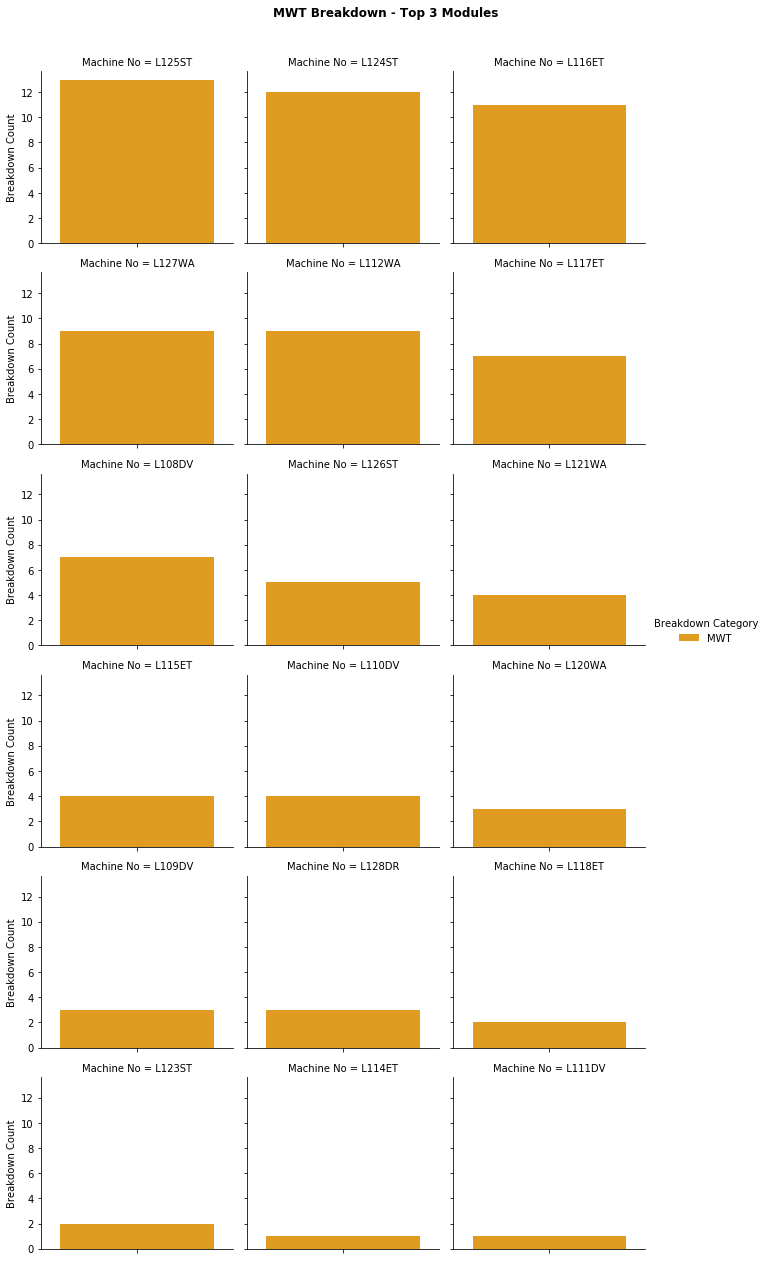

In [49]:
#top_breakdowns = ['EBD ', 'PMP ', 'MWT ']
topone_breakdowns = ['MWT ']

comparison_3 = {'Machine No': [], 'Breakdown Category': []}
comparison_3['Machine No'] = final_ca['MC.No ']
comparison_3['Breakdown Category'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(topone_breakdowns)]
comparison_3 = pd.DataFrame(comparison_3)
comparison_3 = comparison_3.groupby('Machine No')['Breakdown Category'].value_counts().sort_values(ascending= False)
comparison_3 = comparison_3.groupby('Machine No').head(3)
df3 = pd.DataFrame(comparison_3).rename(columns={'Breakdown Category':'Count'})
df3 = df3.reset_index()
#print(df3)


g = sns.FacetGrid(df3, col='Machine No', hue='Breakdown Category', col_wrap=3)
g.map_dataframe(sns.barplot, x= 'Breakdown Category', y= 'Count', data= df, color= 'Orange')
g.set_axis_labels('', 'Breakdown Count')
g.add_legend()
g.set(xticklabels=[])

plt.subplots_adjust(top=0.93)
g.fig.suptitle("MWT Breakdown - Top 3 Modules", weight='bold')

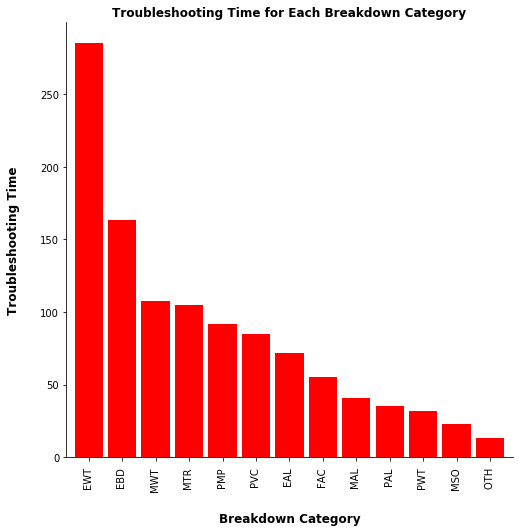

In [50]:
#07 : Breakdown Category vs Troubleshooting Time

# Create a dataframe for comparison #6
comparison_6 = {'Breakdown Category': [], 'Required Troubleshooting Time': []}
comparison_6['Breakdown Category'] = ca['Breakdown Repair Category ']
comparison_6['Required Troubleshooting Time'] = ca['Troubleshoot Hours (mins) ']
comparison_6 = pd.DataFrame(comparison_6)

# Check of no of people required for each unique entries of breakdown category
hx = comparison_6.groupby(['Breakdown Category']).mean().sort_values(by='Required Troubleshooting Time',ascending=False).plot(kind='bar', figsize=(8, 8), color='red', zorder=2, width=0.85)

# Despine
hx.spines['right'].set_visible(False)
hx.spines['top'].set_visible(False)

# Set x-axis label
hx.set_xlabel("Breakdown Category", labelpad=20, weight='bold', size=12)

# Set y-axis label
hx.set_ylabel("Troubleshooting Time", labelpad=20, weight='bold', size=12)

hx.set_title('Troubleshooting Time for Each Breakdown Category', weight='bold')
hx.get_legend().remove()

In [51]:
comparison_6.groupby(['Breakdown Category']).mean().sort_values(by='Required Troubleshooting Time',ascending=False)

,Required Troubleshooting Time
Breakdown Category,
EWT,285.164835
EBD,163.377193
MWT,107.450000
MTR,105.000000
PMP,91.363636
PVC,84.545455
EAL,71.384615
FAC,55.000000
MAL,40.462963


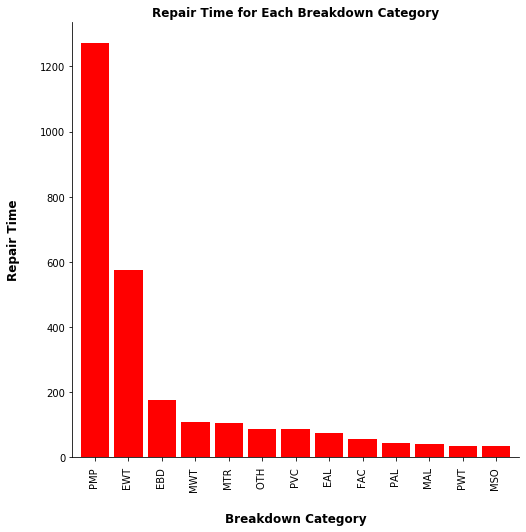

In [52]:
#08 : Breakdown Category vs Repair Time

# Create a dataframe for comparison #6
comparison_7 = {'Breakdown Category': [], 'Required Repair Time': []}
comparison_7['Breakdown Category'] = ca['Breakdown Repair Category ']
comparison_7['Required Repair Time'] = ca['Repair Hours (mins) ']
comparison_7 = pd.DataFrame(comparison_7)

# Check of no of people required for each unique entries of breakdown category
hx = comparison_7.groupby(['Breakdown Category']).mean().sort_values(by='Required Repair Time',ascending=False).plot(kind='bar', figsize=(8, 8), color='red', zorder=2, width=0.85)

# Despine
hx.spines['right'].set_visible(False)
hx.spines['top'].set_visible(False)

# Set x-axis label
hx.set_xlabel("Breakdown Category", labelpad=20, weight='bold', size=12)

# Set y-axis label
hx.set_ylabel("Repair Time", labelpad=20, weight='bold', size=12)

hx.set_title('Repair Time for Each Breakdown Category', weight='bold')
hx.get_legend().remove()

In [53]:
comparison_7.groupby(['Breakdown Category']).mean().sort_values(by='Required Repair Time',ascending=False)

,Required Repair Time
Breakdown Category,
PMP,1271.909091
EWT,573.681319
EBD,174.692982
MWT,109.250000
MTR,105.000000
OTH,86.363636
PVC,85.965909
EAL,73.307692
FAC,55.000000


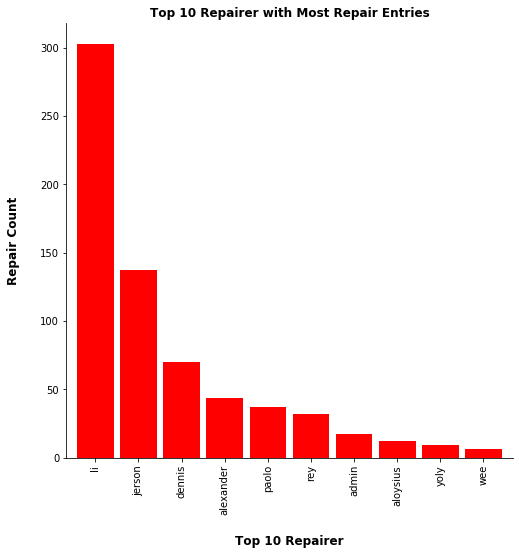

In [54]:
#09 Top 10 counts of entries/repairs done by each repairer

top_entry = final_ca['Repairer Name'].value_counts().to_frame().head(10)
top_entries = top_entry.plot(kind='bar', figsize=(8, 8), color='red', zorder=2, width=0.85)

# Despine
top_entries.spines['right'].set_visible(False)
top_entries.spines['top'].set_visible(False)

# Set x-axis label
top_entries.set_xlabel("Top 10 Repairer", labelpad=20, weight='bold', size=12)

# Set y-axis label
top_entries.set_ylabel("Repair Count", labelpad=20, weight='bold', size=12)

top_entries.set_title('Top 10 Repairer with Most Repair Entries', weight='bold')
top_entries.get_legend().remove()

           Required Troubleshooting Time
Repairer                                
li                            153.432343
jerson                        138.284672
dennis                         90.857143
yoly                           77.222222
alexander                      70.340909
aloysius                       58.333333
rey                            54.843750
paolo                          51.621622
wee                            31.666667
admin                           6.470588


Text(0.5, 1.0, 'Average Troubleshooting Time for Top 10 Repairer')

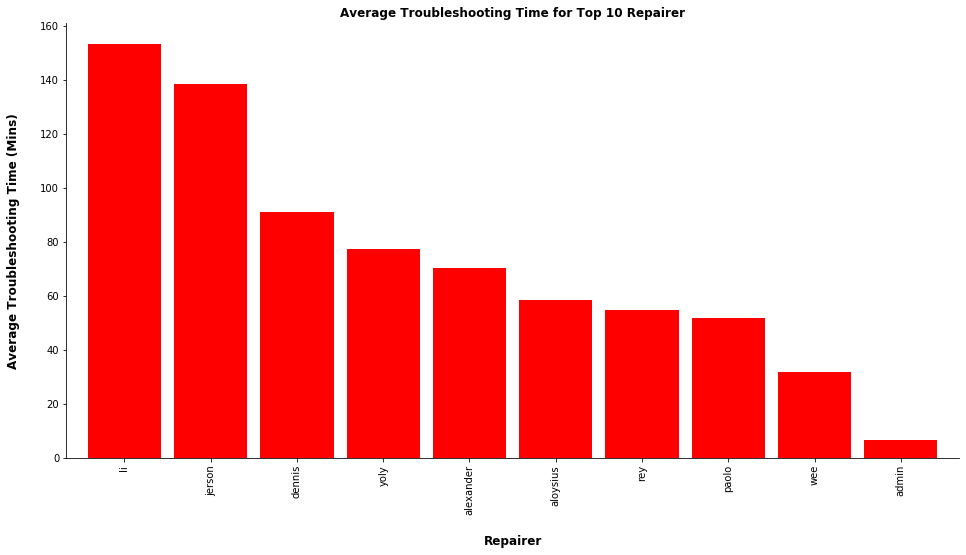

In [55]:
#10 : Repairer vs Troubleshooting Time

# Create a dataframe for comparison #8
top_10count_repairers = ['li', 'jerson', 'dennis', 'alexander', 'paolo', 'rey', 'admin', 'aloysius', 'yoly', 'wee']
comparison_8 = {'Repairer': [], 'Required Troubleshooting Time': []}
comparison_8['Repairer'] = final_ca['Repairer Name'].loc[final_ca['Repairer Name'].isin(top_10count_repairers)]
comparison_8['Required Troubleshooting Time'] = final_ca['Troubleshoot Hours (mins) ']
comparison_8 = pd.DataFrame(comparison_8)

print(comparison_8.groupby('Repairer')['Required Troubleshooting Time'].mean().sort_values(ascending=False).to_frame())

# Check of no of people required for each unique entries of breakdown category
hx = comparison_8.groupby('Repairer')['Required Troubleshooting Time'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(16, 8), color='red', zorder=2, width=0.85)

# Despine
hx.spines['right'].set_visible(False)
hx.spines['top'].set_visible(False)

# Set x-axis label
hx.set_xlabel("Repairer", labelpad=20, weight='bold', size=12)

# Set y-axis label
hx.set_ylabel("Average Troubleshooting Time (Mins)", labelpad=20, weight='bold', size=12)

hx.set_title('Average Troubleshooting Time for Top 10 Repairer', weight='bold')

# go into why li use longer troubleshooting time..
# goes into the most important or fault always occurs, then go into the time the repairer takes for the fault

In [56]:
comparison_8.groupby('Repairer')['Required Troubleshooting Time'].mean().sort_values(ascending=False).to_frame()

,Required Troubleshooting Time
Repairer,
li,153.432343
jerson,138.284672
dennis,90.857143
yoly,77.222222
alexander,70.340909
aloysius,58.333333
rey,54.843750
paolo,51.621622
wee,31.666667


           Required Repair Time
Repairer                       
li                   672.326733
jerson               140.255474
alexander             97.613636
dennis                90.928571
yoly                  80.000000
rey                   64.375000
aloysius              59.166667
paolo                 51.756757
wee                   33.333333
admin                 13.235294


Text(0.5, 1.0, 'Average Repair Time for Top 10 Repairer')

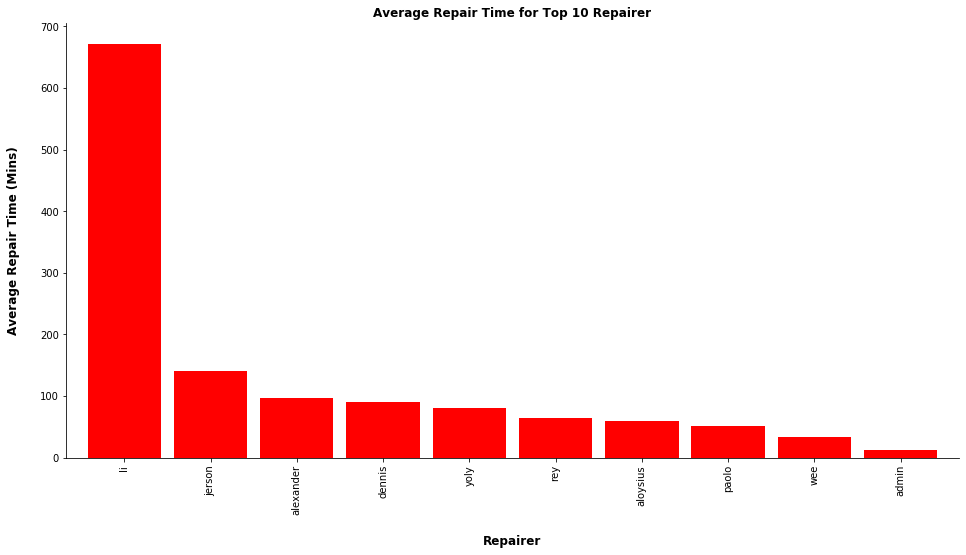

In [57]:
#11 : Repairer vs Repair Time

# Create a dataframe for comparison #9
comparison_9 = {'Repairer': [], 'Required Repair Time': []}
comparison_9['Repairer'] = final_ca['Repairer Name'].loc[final_ca['Repairer Name'].isin(top_10count_repairers)]
comparison_9['Required Repair Time'] = final_ca['Repair Hours (mins) '] 
comparison_9 = pd.DataFrame(comparison_9) 

print(comparison_9.groupby('Repairer')['Required Repair Time'].mean().sort_values(ascending=False).to_frame().head(10))

# Check of no of people required for each unique entries of breakdown category
hx = comparison_9.groupby('Repairer')['Required Repair Time'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(16, 8), color='red', zorder=2, width=0.85)

# Despine
hx.spines['right'].set_visible(False)
hx.spines['top'].set_visible(False)

# Set x-axis label
hx.set_xlabel("Repairer", labelpad=20, weight='bold', size=12)

# Set y-axis label
hx.set_ylabel("Average Repair Time (Mins)", labelpad=20, weight='bold', size=12)

hx.set_title('Average Repair Time for Top 10 Repairer', weight='bold')

In [58]:
comparison_9.groupby('Repairer')['Required Repair Time'].mean().sort_values(ascending=False).to_frame().head(10)

,Required Repair Time
Repairer,
li,672.326733
jerson,140.255474
alexander,97.613636
dennis,90.928571
yoly,80.000000
rey,64.375000
aloysius,59.166667
paolo,51.756757
wee,33.333333


Text(0.5, 0.98, 'Average Troubleshooting Time of Repairers')

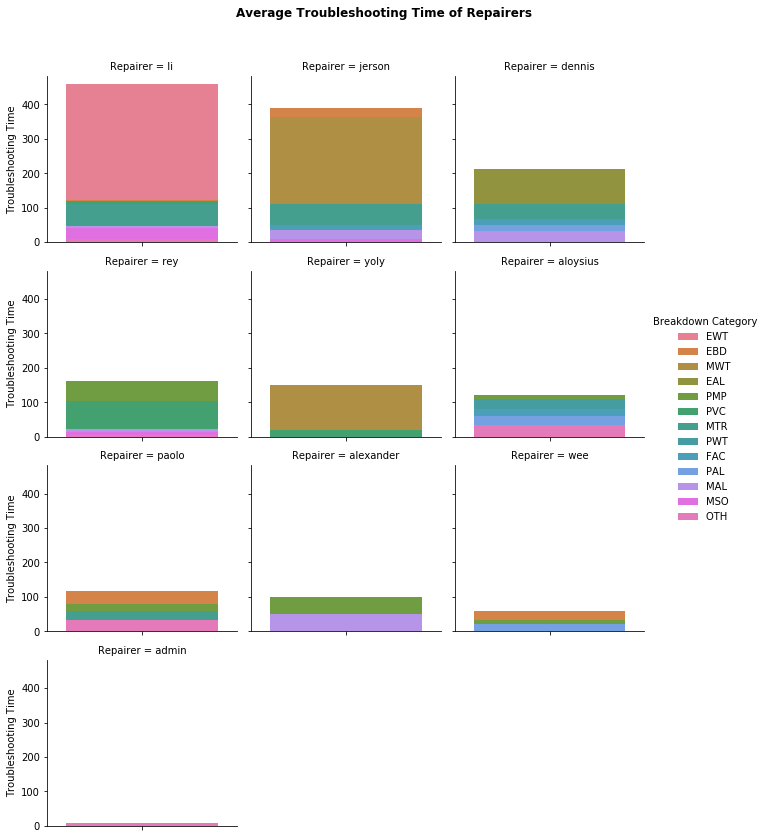

In [59]:
#12 Average Troubleshooting Time of Repairers based on Breakdown Repair Category

top_10count_repairers = ['li', 'jerson', 'dennis', 'alexander', 'paolo', 'rey', 'admin', 'aloysius', 'yoly', 'wee']

comparison_10 = {'Repairer': [], 'Breakdown Category': [], 'Required Troubleshooting Time': []}
comparison_10['Repairer'] = final_ca['Repairer Name'].loc[final_ca['Repairer Name'].isin(top_10count_repairers)]
comparison_10['Breakdown Category'] = final_ca['Breakdown Repair Category ']
comparison_10['Required Troubleshooting Time'] = final_ca['Troubleshoot Hours (mins) ']
comparison_10 = pd.DataFrame(comparison_10)
comparison_10 = comparison_10.groupby(['Repairer', 'Breakdown Category'])['Required Troubleshooting Time'].mean().sort_values(ascending=False)
comparison_10 = pd.DataFrame(comparison_10)
df10 = pd.DataFrame(comparison_10).rename(columns={'Required Troubleshooting Time':'Mean Troubleshooting Time'})
df10 = df10.reset_index()
#print(df10)


g = sns.FacetGrid(df10, col='Repairer', hue='Breakdown Category', col_wrap=3)
g.map_dataframe(sns.barplot, x= 'Breakdown Category', y= 'Mean Troubleshooting Time', data= df10)
g.set_axis_labels('', 'Troubleshooting Time')
g.add_legend()
g.set(xticklabels=[])

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Average Troubleshooting Time of Repairers", weight='bold')

Text(0.5, 0.98, 'Average Repair Time of Repairers')

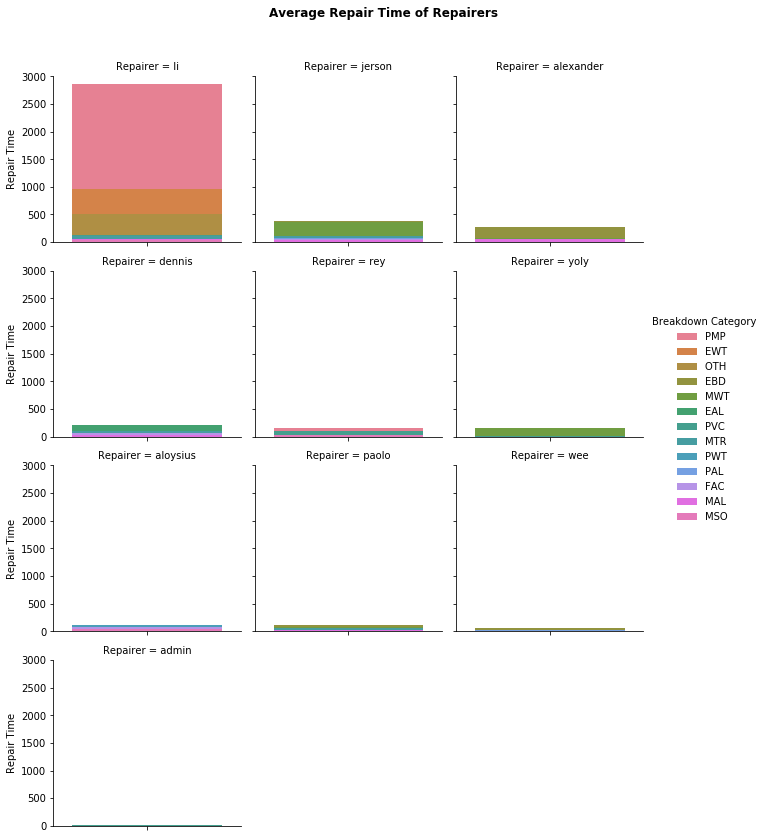

In [60]:
#13 Average Repair Time of Repairers based on Breakdown Repair Category

top_10count_repairers = ['li', 'jerson', 'dennis', 'alexander', 'paolo', 'rey', 'admin', 'aloysius', 'yoly', 'wee']

comparison_11 = {'Repairer': [], 'Breakdown Category': [], 'Required Repair Time': []}
comparison_11['Repairer'] = final_ca['Repairer Name'].loc[final_ca['Repairer Name'].isin(top_10count_repairers)]
comparison_11['Breakdown Category'] = final_ca['Breakdown Repair Category ']
comparison_11['Required Repair Time'] = final_ca['Repair Hours (mins) ']
comparison_11 = pd.DataFrame(comparison_11)
comparison_11 = comparison_11.groupby(['Repairer', 'Breakdown Category'])['Required Repair Time'].mean().sort_values(ascending=False)
comparison_11 = pd.DataFrame(comparison_11)
df11 = pd.DataFrame(comparison_11).rename(columns={'Required Repair Time':'Mean Repair Time'})
df11 = df11.reset_index()
#print(df11)


g = sns.FacetGrid(df11, col='Repairer', hue='Breakdown Category', col_wrap=3)
g.map_dataframe(sns.barplot, x= 'Breakdown Category', y= 'Mean Repair Time', data= df11)
g.set_axis_labels('', 'Repair Time')
g.add_legend()
g.set(xticklabels=[])

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Average Repair Time of Repairers", weight='bold')

In [61]:
top_10count_repairers = ['li', 'jerson', 'dennis', 'alexander', 'paolo', 'rey', 'admin', 'aloysius', 'yoly', 'wee']

comparison_10 = {'Repairer': [], 'Breakdown Category': [], 'Required Troubleshooting Time': []}
comparison_10['Repairer'] = final_ca['Repairer Name'].loc[final_ca['Repairer Name'].isin(top_10count_repairers)]
comparison_10['Breakdown Category'] = final_ca['Breakdown Repair Category ']
comparison_10['Required Troubleshooting Time'] = final_ca['Troubleshoot Hours (mins) ']
comparison_10 = pd.DataFrame(comparison_10)
comparison_10 = comparison_10.groupby(['Repairer', 'Breakdown Category'])['Required Troubleshooting Time'].mean()
comparison_10 = pd.DataFrame(comparison_10)
df10 = pd.DataFrame(comparison_10).rename(columns={'Required Troubleshooting Time':'Mean Troubleshooting Time'})


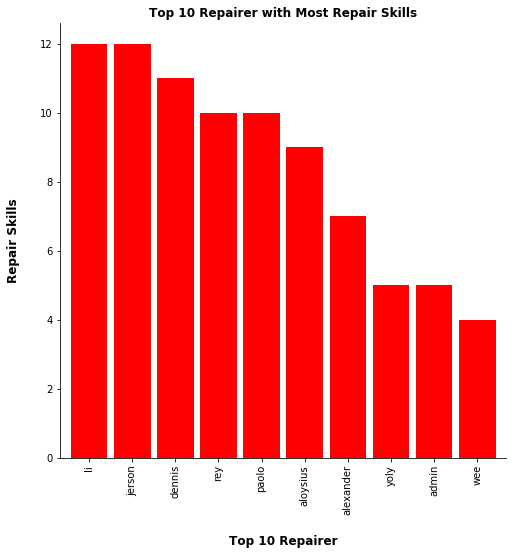

In [62]:
#14 Top 10 Repairer with Most Repair Skills

top_10count_repairers = ['li', 'jerson', 'dennis', 'alexander', 'paolo', 'rey', 'admin', 'aloysius', 'yoly', 'wee']

comparison_120 = {'Repairer': [], 'Breakdown': []}
comparison_120['Repairer'] = final_ca['Repairer Name'].loc[final_ca['Repairer Name'].isin(top_10count_repairers)]
comparison_120['Breakdown'] = final_ca['Breakdown Repair Category ']
comparison_120 = pd.DataFrame(comparison_120)
comparison_120 = comparison_120.groupby(['Repairer'])['Breakdown'].nunique().sort_values(ascending=False)
comparison_120 = pd.DataFrame(comparison_120)
df120 = pd.DataFrame(comparison_120).rename(columns={'Breakdown':'Skills'})
#df120 = df120.reset_index()
#print(df120)
#df120.set_index('Repairer')

top_skills = df120.plot(kind='bar', figsize=(8, 8), color='red', zorder=2, width=0.85)

# Despine
top_skills.spines['right'].set_visible(False)
top_skills.spines['top'].set_visible(False)

# Set x-axis label
top_skills.set_xlabel("Top 10 Repairer", labelpad=20, weight='bold', size=12)

# Set y-axis label
top_skills.set_ylabel("Repair Skills", labelpad=20, weight='bold', size=12)

top_skills.set_title('Top 10 Repairer with Most Repair Skills', weight='bold')
top_skills.get_legend().remove()


Text(0.5, 0.98, 'Average Troubleshooting Time of Top Repairers')

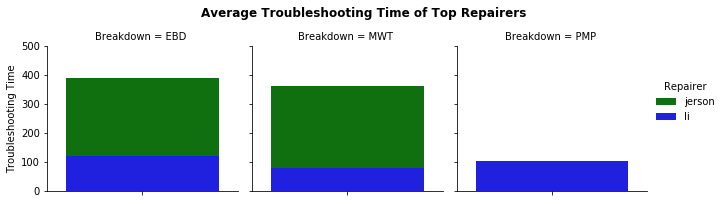

In [63]:
#15 Top Repairer Average Troubleshooting Time vs Top 3 Breakdown Categories

top_repairers = ['li', 'jerson']
top_breakdowns = ['EBD ', 'PMP ', 'MWT ']

comparison_13 = {'Breakdown': [], 'Repairer': [], 'Required Troubleshooting Time': []}

comparison_13['Breakdown'] = final_ca['Breakdown Repair Category ']
comparison_13['Repairer'] = final_ca['Repairer Name'].loc[final_ca['Repairer Name'].isin(top_repairers)]
comparison_13['Required Troubleshooting Time'] = final_ca['Troubleshoot Hours (mins) ']
comparison_13 = pd.DataFrame(comparison_13)
comparison_13 = comparison_13.groupby(['Breakdown', 'Repairer'])['Required Troubleshooting Time'].mean()
comparison_13 = pd.DataFrame(comparison_13)
df13 = pd.DataFrame(comparison_13).rename(columns={'Required Troubleshooting Time':'Mean Troubleshooting Time'})
df13 = df13.reset_index()
df13 = df13.loc[df13['Breakdown'].isin(top_breakdowns)]

g = sns.FacetGrid(df13, col='Breakdown', hue='Repairer', col_wrap=3)
g.map_dataframe(sns.barplot, x= 'Repairer', y= 'Mean Troubleshooting Time', data= df13)
g.set_axis_labels('', 'Troubleshooting Time')
g.add_legend()
g.set(xticklabels=[])
g.set(ylim=(0, 500))


plt.subplots_adjust(top=0.8)
g.fig.suptitle("Average Troubleshooting Time of Top Repairers", weight='bold')

In [64]:
top_repairers = ['li', 'jerson']
top_breakdowns = ['EBD ', 'PMP ', 'MWT ']

comparison_13 = {'Breakdown': [], 'Repairer': [], 'Required Troubleshooting Time': []}

comparison_13['Breakdown'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(top_breakdowns)]
comparison_13['Repairer'] = final_ca['Repairer Name'].loc[final_ca['Repairer Name'].isin(top_repairers)]
comparison_13['Required Troubleshooting Time'] = final_ca['Troubleshoot Hours (mins) ']
comparison_13 = pd.DataFrame(comparison_13)
comparison_13 = comparison_13.groupby(['Breakdown', 'Repairer'])['Required Troubleshooting Time'].mean()
comparison_13 = pd.DataFrame(comparison_13)
df13 = pd.DataFrame(comparison_13).rename(columns={'Required Troubleshooting Time':'Mean Troubleshooting Time'})
df13

Mean Troubleshooting Time
Breakdown Repairer                           
EBD       jerson                   390.200000
          li                       121.636364
MWT       jerson                   362.777778
          li                        77.177419
PMP       jerson                    67.380952
          li                       101.489362

Text(0.5, 0.98, 'Average Repair Time of Top Repairers')

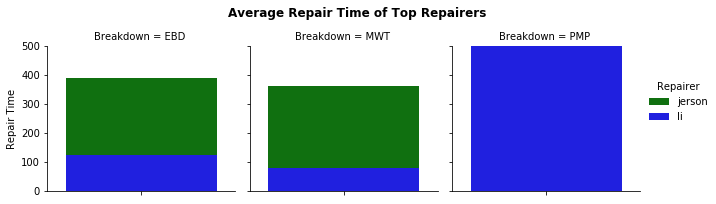

In [65]:
#15 Top Repairer Average Repair Time vs Top 3 Breakdown Categories

top_repairers = ['li', 'jerson']
top_breakdowns = ['EBD ', 'PMP ', 'MWT ']

comparison_14 = {'Breakdown': [], 'Repairer': [], 'Required Repair Time': []}

comparison_14['Breakdown'] = final_ca['Breakdown Repair Category ']
comparison_14['Repairer'] = final_ca['Repairer Name'].loc[final_ca['Repairer Name'].isin(top_repairers)]
comparison_14['Required Repair Time'] = final_ca['Repair Hours (mins) ']
comparison_14 = pd.DataFrame(comparison_14)
comparison_14 = comparison_14.groupby(['Breakdown', 'Repairer'])['Required Repair Time'].mean()
comparison_14 = pd.DataFrame(comparison_14)
df14 = pd.DataFrame(comparison_14).rename(columns={'Required Repair Time':'Mean Repair Time'})
df14 = df14.reset_index()
df14 = df14.loc[df14['Breakdown'].isin(top_breakdowns)]

g = sns.FacetGrid(df14, col='Breakdown', hue='Repairer', col_wrap=3)
g.map_dataframe(sns.barplot, x= 'Repairer', y= 'Mean Repair Time', data= df14)
g.set_axis_labels('', 'Repair Time')
g.add_legend()
g.set(xticklabels=[])
g.set(ylim=(0, 500))

plt.subplots_adjust(top=0.8)
g.fig.suptitle("Average Repair Time of Top Repairers", weight='bold')


In [66]:
top_repairers = ['li', 'jerson']
top_breakdowns = ['EBD ', 'PMP ', 'MWT ']

comparison_14 = {'Breakdown': [], 'Repairer': [], 'Required Repair Time': []}

comparison_14['Breakdown'] = final_ca['Breakdown Repair Category '].loc[final_ca['Breakdown Repair Category '].isin(top_breakdowns)]
comparison_14['Repairer'] = final_ca['Repairer Name'].loc[final_ca['Repairer Name'].isin(top_repairers)]
comparison_14['Required Repair Time'] = final_ca['Repair Hours (mins) ']
comparison_14 = pd.DataFrame(comparison_14)
comparison_14 = comparison_14.groupby(['Breakdown', 'Repairer'])['Required Repair Time'].mean()
comparison_14 = pd.DataFrame(comparison_14)
df14 = pd.DataFrame(comparison_14).rename(columns={'Required Repair Time':'Mean Repair Time'})
df14

Mean Repair Time
Breakdown Repairer                  
EBD       jerson          390.600000
          li              122.181818
MWT       jerson          362.777778
          li               77.419355
PMP       jerson           67.857143
          li             2861.702128

## 5. Predicting Troubleshooting and Repair Time

In [67]:
final_ca['Action Taken'] = final_ca['Action Taken'].str.replace('[!,",#,$,%,&,\,(,),*,+,,,-,.,/,:,;,<,=,>,?,@,[,\,\,],^,_,`,{,|,},~,]', ' ')

In [68]:
import string
alphabet = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
final_ca['Action Taken'].str.strip(alphabet).any()

'replace some worn out oring @ develoving roller'

In [69]:
final_ca['Action Taken'] = final_ca['Action Taken'].apply(str)

In [70]:
nlp_ca = final_ca.copy()

In [71]:
nlp_ca.drop(columns = ['MC.No ', 'MC.Name ', 'Report Date & Time',
       'Problem Description', 'M/C Status When Attend ',
       'M/C Status During Repair', 'M/C Status After Attend',
       'No of people attend',
       'Actual Repair Start Time(Attend Date) ', 'Troubleshoot Complete Time',
       'Actual Repair Complete Time(Complete Date)',
       'Fab/Spare parts sourcing Time(mins)',
       'KIV Reason ', 'Qty Required ', 'Wait AM/PM ',
       'Attend Wait time (mins) ', 'Rectify Hours (mins) '])

,Action Taken,Breakdown Repair Category,Troubleshoot Hours (mins),Repair Hours (mins),Repairer Name,Process,Year,Month
0,replace some worn out oring @ develoving roller,MWT,35.0,35.0,jerson,Developing,2014,2
1,clean sensor and reset system.,EBD,50.0,50.0,li,Developing,2014,2
2,replace the pvc filter connector.,PVC,30.0,30.0,jerson,Developing,2014,3
3,-trim and re-connect broken airhose.,PWT,15.0,15.0,dennis,Developing,2014,4
4,replace air connector.,PWT,20.0,20.0,li,Developing,2014,5
...,...,...,...,...,...,...,...,...
695,replace the water flow meter.,MAL,30.0,30.0,li,Water Rinse,2019,3
696,check found flow meter glass clip already spoi...,MWT,80.0,80.0,jerson,Water Rinse,2019,6
697,replace the pump,PMP,60.0,60.0,li,Water Rinse,2019,7
698,tighten the flow meter.,PVC,20.0,20.0,li,Water Rinse,2019,7


In [72]:
nlp_ca['text_lower'] = nlp_ca['Action Taken'].str.lower()

In [73]:
import string

punct_to_remove = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punct_to_remove))

nlp_ca["text_wo_punct"] = nlp_ca["text_lower"].apply(lambda text: remove_punctuation(text))

In [74]:
nlp_ca['text_token'] = [word_tokenize(entry) for entry in nlp_ca['text_wo_punct']]

In [75]:
stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    return [w for w in text if not w in stopwords]

nlp_ca['text_wo_stop'] = nlp_ca['text_token'].apply(lambda x : remove_stopwords(x))

In [76]:
wnl = WordNetLemmatizer()

def lemmatize_words(text):
    return [wnl.lemmatize(word) for word in text]

nlp_ca["text_lemmatized"] = nlp_ca["text_wo_stop"].apply(lambda text: lemmatize_words(text))

nlp_ca

,MC.No,MC.Name,Report Date & Time,Problem Description,M/C Status When Attend,M/C Status During Repair,M/C Status After Attend,No of people attend,Action Taken,Actual Repair Start Time(Attend Date),Troubleshoot Complete Time,Actual Repair Complete Time(Complete Date),Fab/Spare parts sourcing Time(mins),Breakdown Repair Category,KIV Reason,Qty Required,Wait AM/PM,Attend Wait time (mins),Troubleshoot Hours (mins),Rectify Hours (mins),Repair Hours (mins),Repairer Name,Process,Year,Month,text_lower,text_wo_punct,text_token,text_wo_stop,text_lemmatized
0,L108DV,IL DES 4-Chemical Developing 1,2014-02-20 03:55:15,few rollers with loose 'o' ring causing pnl ov...,SWA,SDR,OK,1.0,replace some worn out oring @ develoving roller,2014-02-20 04:00:00,2014-02-20 04:35:00,2014-02-20 04:35:00,0.0,MWT,Not Applicable,0.0,PM,5.0,35.0,0.0,35.0,jerson,Developing,2014,2,replace some worn out oring @ develoving roller,replace some worn out oring develoving roller,"[replace, some, worn, out, oring, develoving, ...","[replace, worn, oring, develoving, roller]","[replace, worn, oring, develoving, roller]"
1,L108DV,IL DES 4-Chemical Developing 1,2014-02-26 16:53:06,dev system level sensor data jammed...chemical...,SWA,SDR,OK,1.0,clean sensor and reset system.,2014-02-26 17:00:00,2014-02-26 17:50:00,2014-02-26 17:50:00,0.0,EBD,Not Applicable,0.0,AM,7.0,50.0,0.0,50.0,li,Developing,2014,2,clean sensor and reset system.,clean sensor and reset system,"[clean, sensor, and, reset, system]","[clean, sensor, reset, system]","[clean, sensor, reset, system]"
2,L108DV,IL DES 4-Chemical Developing 1,2014-03-31 05:12:26,filter pipe leaking,NP,NP,OK,1.0,replace the pvc filter connector.,2014-03-31 05:30:00,2014-03-31 06:00:00,2014-03-31 06:00:00,0.0,PVC,Not Applicable,0.0,PM,18.0,30.0,0.0,30.0,jerson,Developing,2014,3,replace the pvc filter connector.,replace the pvc filter connector,"[replace, the, pvc, filter, connector]","[replace, pvc, filter, connector]","[replace, pvc, filter, connector]"
3,L108DV,IL DES 4-Chemical Developing 1,2014-04-28 20:47:53,air hose leaking,RWA,RDR,OK,1.0,-trim and re-connect broken airhose.,2014-04-28 21:00:00,2014-04-28 21:15:00,2014-04-28 21:15:00,0.0,PWT,Not Applicable,0.0,PM,13.0,15.0,0.0,15.0,dennis,Developing,2014,4,-trim and re-connect broken airhose.,trim and reconnect broken airhose,"[trim, and, reconnect, broken, airhose]","[trim, reconnect, broken, airhose]","[trim, reconnect, broken, airhose]"
4,L108DV,IL DES 4-Chemical Developing 1,2014-05-19 14:04:31,air leakage,RWA,RDR,OK,1.0,replace air connector.,2014-05-19 14:40:00,2014-05-19 15:00:00,2014-05-19 15:00:00,0.0,PWT,Not Applicable,0.0,AM,36.0,20.0,0.0,20.0,li,Developing,2014,5,replace air connector.,replace air connector,"[replace, air, connector]","[replace, air, connector]","[replace, air, connector]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,L127WA,IL DES 4-Water Rinse (Stripping),2019-03-13 08:58:51,water pipe leaking...pls come check thx,RWA,RDR,OK,1.0,replace the water flow meter.,2019-03-13 09:00:00,2019-03-13 09:30:00,2019-03-13 09:30:00,0.0,MAL,Not Applicable,0.0,AM,2.0,30.0,0.0,30.0,li,Water Rinse,2019,3,replace the water flow meter.,replace the water flow meter,"[replace, the, water, flow, meter]","[replace, water, flow, meter]","[replace, water, flow, meter]"
696,L127WA,IL DES 4-Water Rinse (Stripping),2019-06-02 20:24:26,water pipe leaking,SWA,SDR,OK,1.0,check found flow meter glass clip already spoi...,2019-06-02 22:00:00,2019-06-02 23:20:00,2019-06-02 23:20:00,0.0,MWT,Not Applicable,0.0,PM,96.0,80.0,0.0,80.0,jerson,Water Rinse,2019,6,check found flow meter glass clip already spoi...,check found flow meter glass clip already spoi...,"[check, found, flow, meter, glass, clip, alrea...","[check, found, flow, meter, glass, clip, alrea...","[check, found, flow, meter, glass, clip, alrea..."
697,L127WA,IL DES 4-Water Rinse (Stripping),2019-07-09 12:51:10,new water pump trip come to c

In [77]:
nlp_final = nlp_ca[['text_lemmatized','Breakdown Repair Category ', 'Troubleshoot Hours (mins) ', 'Repair Hours (mins) ', 'Repairer Name']]

nlp_final

,text_lemmatized,Breakdown Repair Category,Troubleshoot Hours (mins),Repair Hours (mins),Repairer Name
0,"[replace, worn, oring, develoving, roller]",MWT,35.0,35.0,jerson
1,"[clean, sensor, reset, system]",EBD,50.0,50.0,li
2,"[replace, pvc, filter, connector]",PVC,30.0,30.0,jerson
3,"[trim, reconnect, broken, airhose]",PWT,15.0,15.0,dennis
4,"[replace, air, connector]",PWT,20.0,20.0,li
...,...,...,...,...,...
695,"[replace, water, flow, meter]",MAL,30.0,30.0,li
696,"[check, found, flow, meter, glass, clip, alrea...",MWT,80.0,80.0,jerson
697,"[replace, pump]",PMP,60.0,60.0,li
698,"[tighten, flow, meter]",PVC,20.0,20.0,li


## ML Model Building

In [78]:
model = nlp_final.copy()
model.drop('text_lemmatized',
  axis='columns', inplace=True)
model

,Breakdown Repair Category,Troubleshoot Hours (mins),Repair Hours (mins),Repairer Name
0,MWT,35.0,35.0,jerson
1,EBD,50.0,50.0,li
2,PVC,30.0,30.0,jerson
3,PWT,15.0,15.0,dennis
4,PWT,20.0,20.0,li
...,...,...,...,...
695,MAL,30.0,30.0,li
696,MWT,80.0,80.0,jerson
697,PMP,60.0,60.0,li
698,PVC,20.0,20.0,li


In [79]:
# Replace string and organize the values of the columns

breakdown_cat = [
    (model['Breakdown Repair Category '] == 'EAL '),
    (model['Breakdown Repair Category '] == 'EBD '),
    (model['Breakdown Repair Category '] == 'EWT '),
    (model['Breakdown Repair Category '] == 'FAC '),
    (model['Breakdown Repair Category '] == 'MAL '),
    (model['Breakdown Repair Category '] == 'MSO '),
    (model['Breakdown Repair Category '] == 'MTR '),
    (model['Breakdown Repair Category '] == 'MWT '),
    (model['Breakdown Repair Category '] == 'OTH '),
    (model['Breakdown Repair Category '] == 'PAL '),
    (model['Breakdown Repair Category '] == 'PMP '),
    (model['Breakdown Repair Category '] == 'PVC '),
    (model['Breakdown Repair Category '] == 'PWT ')
    ]

# create a list of the values we want to assign for each condition
breakdown_values = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# create a new column and use np.select to assign values to it using our lists as arguments
model['BreakdownCat'] = np.select(breakdown_cat, breakdown_values)


# display updated DataFrame

model.head()

,Breakdown Repair Category,Troubleshoot Hours (mins),Repair Hours (mins),Repairer Name,BreakdownCat
0,MWT,35.0,35.0,jerson,7
1,EBD,50.0,50.0,li,1
2,PVC,30.0,30.0,jerson,11
3,PWT,15.0,15.0,dennis,12
4,PWT,20.0,20.0,li,12


In [80]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
model['BreakdownCat'] = model.apply(le.fit_transform)
model.head()

,Breakdown Repair Category,Troubleshoot Hours (mins),Repair Hours (mins),Repairer Name,BreakdownCat
0,MWT,35.0,35.0,jerson,7
1,EBD,50.0,50.0,li,1
2,PVC,30.0,30.0,jerson,11
3,PWT,15.0,15.0,dennis,12
4,PWT,20.0,20.0,li,12


In [81]:
model.corr()

,Troubleshoot Hours (mins),Repair Hours (mins),BreakdownCat
Troubleshoot Hours (mins),1.000000,0.085649,-0.073771
Repair Hours (mins),0.085649,1.000000,0.026329
BreakdownCat,-0.073771,0.026329,1.000000


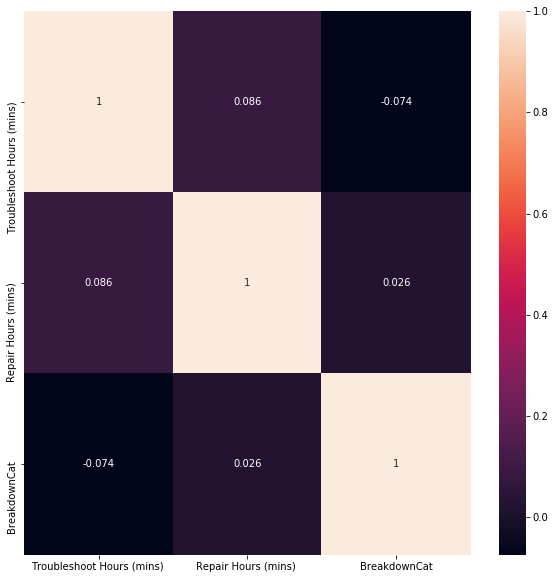

In [82]:
plt.figure(figsize = (10, 10))
sns.heatmap(model.corr(), annot = True)

* The features do not really have a correlation with each other

## Troubleshoot Prediction (Linear Regression)

In [103]:
t_target = np.array(model['Troubleshoot Hours (mins) '])

In [104]:
t_features = np.array(model.drop(['Troubleshoot Hours (mins) ', 'Repair Hours (mins) ', 'Repairer Name', 'Troubleshoot Hours (mins) ', 'Breakdown Repair Category '] ,  axis=1))

In [105]:
t_target = t_target.reshape(694,1)
r_features = t_features.reshape(694,1)

In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(t_features, t_target, test_size = 0.2, random_state = 123)

([], <a list of 0 Text yticklabel objects>)

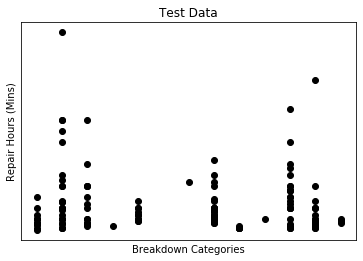

In [107]:
# Plot outputs 
plt.scatter(X_test, y_test,  color='black') 
plt.title('Test Data') 
plt.xlabel('Breakdown Categories') 
plt.ylabel('Repair Hours (Mins)')
plt.xticks(()) 
plt.yticks(()) 

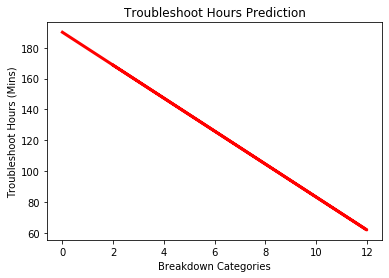

In [108]:
# Create linear regression object 
t_regr = LinearRegression() 
   
# Train the model using the training sets 
t_regr.fit(X_train, y_train) 

#regr.predict(X_test).reshape(1, 1))

# Plot outputs 
plt.plot(X_test, t_regr.predict(X_test), color='red',linewidth=3) 
plt.title('Troubleshoot Hours Prediction') 
plt.xlabel('Breakdown Categories') 
plt.ylabel('Troubleshoot Hours (Mins)')
plt.show()

## Repair Prediction (Linear Regression)

In [109]:
r_target = np.array(model['Repair Hours (mins) '])

In [110]:
r_features = np.array(model.drop(['Repair Hours (mins) ', 'Repairer Name', 'Troubleshoot Hours (mins) ', 'Breakdown Repair Category '] ,  axis=1))

In [111]:
r_target = r_target.reshape(694,1)
r_features = r_features.reshape(694,1)

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(r_features, r_target, test_size = 0.2, random_state = 123)

([], <a list of 0 Text yticklabel objects>)

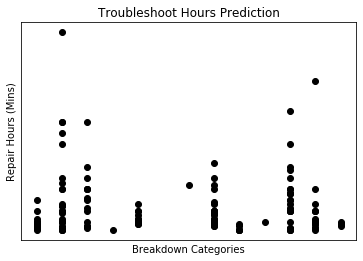

In [113]:
# Plot outputs 
plt.scatter(X_test, y_test,  color='black') 
plt.title('Troubleshoot Hours Prediction') 
plt.xlabel('Breakdown Categories') 
plt.ylabel('Repair Hours (Mins)')
plt.xticks(()) 
plt.yticks(()) 

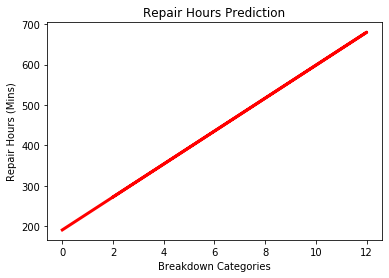

In [114]:
# Create linear regression object 
r_regr = LinearRegression() 
   
# Train the model using the training sets 
r_regr.fit(X_train, y_train) 

#regr.predict(X_test).reshape(1, 1))

# Plot outputs 
plt.plot(X_test, r_regr.predict(X_test), color='red',linewidth=3) 
plt.title('Repair Hours Prediction') 
plt.xlabel('Breakdown Categories') 
plt.ylabel('Repair Hours (Mins)')
plt.show() 

## Predict Troubleshoot and Repair Time based on Breakdown Input

Breakdown Categories:
- EAL
- EBD
- EWT
- FAC
- MAL      
- MSO      
- MTR      
- MWT     
- OTH      
- PAL     
- PMP    
- PVC     
- PWT   

In [117]:
breakdown_type = input("Enter Breakdown Category: ")

if breakdown_type == 'EAL':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[0]])), ), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[0]]))), 'mins' )
elif breakdown_type == 'EBD':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[1]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[1]]))), 'mins' )
elif breakdown_type == 'EWT':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[2]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[2]]))), 'mins' )
elif breakdown_type == 'FAC':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[3]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[3]]))), 'mins' )
elif breakdown_type == 'MAL':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[4]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[4]]))), 'mins' )
elif breakdown_type == 'MSO':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[5]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[5]]))), 'mins' )
elif breakdown_type == 'MTR':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[6]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[6]]))), 'mins' )
elif breakdown_type == 'MWT':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[7]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[7]]))), 'mins' )
elif breakdown_type == 'OTH':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[8]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[8]]))), 'mins' )
elif breakdown_type == 'PAL':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[9]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[9]]))), 'mins' )
elif breakdown_type == 'PMP':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[10]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[10]]))), 'mins' )
elif breakdown_type == 'PVC':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[11]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[11]]))), 'mins' )
elif breakdown_type == 'PWT':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[12]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[12]]))), 'mins' )
    

Enter Breakdown Category: PMP
Predicted Troubleshoot Hours (Mins) for PMP : 83 mins
Predicted Repair Hours (Mins) for PMP : 599 mins


In [120]:
breakdown_type = input("Enter Breakdown Category: ")

if breakdown_type == 'EAL':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[0]])), ), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[0]]))), 'mins' )
elif breakdown_type == 'EBD':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[1]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[1]]))), 'mins' )
elif breakdown_type == 'EWT':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[2]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[2]]))), 'mins' )
elif breakdown_type == 'FAC':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[3]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[3]]))), 'mins' )
elif breakdown_type == 'MAL':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[4]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[4]]))), 'mins' )
elif breakdown_type == 'MSO':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[5]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[5]]))), 'mins' )
elif breakdown_type == 'MTR':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[6]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[6]]))), 'mins' )
elif breakdown_type == 'MWT':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[7]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[7]]))), 'mins' )
elif breakdown_type == 'OTH':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[8]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[8]]))), 'mins' )
elif breakdown_type == 'PAL':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[9]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[9]]))), 'mins' )
elif breakdown_type == 'PMP':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[10]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[10]]))), 'mins' )
elif breakdown_type == 'PVC':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[11]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[11]]))), 'mins' )
elif breakdown_type == 'PWT':
    print('Predicted Troubleshoot Hours (Mins) for', breakdown_type,':', int(np.round(t_regr.predict([[12]]))), 'mins' )
    print('Predicted Repair Hours (Mins) for', breakdown_type,':', int(np.round(r_regr.predict([[12]]))), 'mins' )
    

Enter Breakdown Category: MWT
Predicted Troubleshoot Hours (Mins) for MWT : 115 mins
Predicted Repair Hours (Mins) for MWT : 476 mins
